In [1]:
import pandas as pd
import os
import numpy as np
import json

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import utils

%matplotlib inline
import sklearn.metrics as skl_metrics
from IPython.display import display, Markdown

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)

## Get training data for each model

In [2]:
kiran_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov4_allmodels_cal.csv")
kiran_data = utils.prep_nlst_preds(kiran_nodule, scanlevel=True, sybil=False, tijmen=False)
print(len(kiran_data), "Scans")

10183 Scans


In [3]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [4]:
nlst_democols['cat'].pop('nodule')
nlst_democols['num'].pop('nodule')
nlst_democols['num'].pop('other')
# nlst_democols['cat']['other'].append('Emphysema')
nlst_democols

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'canccolo',
   'cancoral',
   'cancpanc',
   'canccerv',
   'cancstom',
   'cancthyr',
   'canctran',
   'cancnasa',
   'cancla

In [5]:
# kiran_data['WhiteOrBlack'] = kiran_data['race'].replace([3, 4, 5, 6], value=np.nan, inplace=False)
# nlst_democols['cat']['demo'].append('WhiteOrBlack')
# nlst_democols['cat']['other'].append('label')

In [6]:
cols_num = sum(nlst_democols['num'].values(), start=[])
cols_cat = sum(nlst_democols['cat'].values(), start=[])
cols_list = cols_num + cols_cat

Get data for Tijmen's linear layer.

In [7]:
tijmen_train = kiran_data[kiran_data['Thijmen_mean'].isna()]
print("train:", len(tijmen_train), "Scans")
tijmen_val = kiran_data[~kiran_data['Thijmen_mean'].isna()]
print("val:", len(tijmen_val), "Scans")

train: 8121 Scans
val: 2062 Scans


In [8]:
sybil_demos = pd.read_csv(f"{NLST_PREDS}/sybil-nlst-split-demov4.csv")
sybil_demos.nunique()

id                   41280
split                    3
pid                  14185
timepoint                3
SeriesInstanceUID    41280
                     ...  
cigsmok                  2
diagtube                 2
diagchro                 2
marital                  7
study                    3
Length: 86, dtype: int64

In [9]:
sybil_demos['WhiteOrBlack'] = sybil_demos['race'].replace([3, 4, 5, 6], value=np.nan, inplace=False)
sybil_demos['Overweight'] = (sybil_demos['BMI'] >= 25)
sybil_demos['Unfinished_ed'] = (sybil_demos['educat'] == 2) | (sybil_demos['educat'] == 5)

In [10]:
sybil_train = sybil_demos.query('split == "train"')
print(len(sybil_train), 'Scans')

28160 Scans


In [11]:
training_sets = {
    'Kiran': kiran_data,
    'Tijmen': tijmen_train,
    'Sybil': sybil_train
}

## Get Demographic splits (train)

In [12]:
def combine_col_dfs(cols=nlst_democols['cat'], df_func=pd.DataFrame, dfsets=training_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, dfsets)
            if dispdf: display(df)

            df['category'] = [cat] * len(df)
            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-3:] + dfcols[:-3]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

### Categorical columns

In [13]:
def cat_dist_df(c='Gender', dfsets=training_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}_freq"] = dfsets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * dfsets[m][c].value_counts(normalize=True, dropna=False).round(6)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)

    df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [14]:
cat_demo_splits = combine_col_dfs(nlst_democols['cat'], cat_dist_df, training_sets)

In [15]:
display(cat_demo_splits.sort_values(by='diff_norm_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.sort_values(by='diff_norm_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
208,other,Emphysema,True,3697.0,36.3056,2942.0,36.2271,2317.0,8.2280,0.0785,28.0776,27.9991
210,lungcanc,LC_stage,110.0,596.0,5.8529,458.0,5.6397,549.0,1.9496,0.2132,3.9033,3.6901
202,other,FamilyHistoryLungCa,True,2622.0,25.7488,2110.0,25.9820,6232.0,22.1307,-0.2332,3.6181,3.8513
228,lungcanc,Adenocarcinoma,True,539.0,5.2931,410.0,5.0486,558.0,1.9815,0.2445,3.3116,3.0671
59,smoke,cigsmok,1,5088.0,49.9656,4028.0,49.5998,13386.0,47.5355,0.3658,2.4301,2.0643
0,demo,Overweight,False,3220.0,31.6213,2553.0,31.4370,8262.0,29.3395,0.1843,2.2818,2.0975
55,smoke,cigar,0.0,8215.0,80.6737,6544.0,80.5812,22137.0,78.6115,0.0925,2.0622,1.9697
121,disease,diagemph,1.0,1022.0,10.0363,817.0,10.0603,2317.0,8.2280,-0.0240,1.8083,1.8323
13,demo,Gender,2,4349.0,42.7084,3466.0,42.6795,11588.0,41.1506,0.0289,1.5578,1.5289
4,demo,educat,3.0,2538.0,24.9239,2001.0,24.6398,6581.0,23.3700,0.2841,1.5539,1.2698


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
207,other,Emphysema,False,6486.0,63.6944,5179.0,63.7729,25788.0,91.5767,-0.0785,-27.8823,-27.8038
218,lungcanc,LC_stage,NaN,9011.0,88.4906,7210.0,88.7822,26725.0,94.9041,-0.2916,-6.4135,-6.1219
201,other,FamilyHistoryLungCa,False,7561.0,74.2512,6011.0,74.0180,21928.0,77.8693,0.2332,-3.6181,-3.8513
227,lungcanc,Adenocarcinoma,False,9644.0,94.7069,7711.0,94.9514,27602.0,98.0185,-0.2445,-3.3116,-3.0671
58,smoke,cigsmok,0,5095.0,50.0344,4093.0,50.4002,14774.0,52.4645,-0.3658,-2.4301,-2.0643
1,demo,Overweight,True,6963.0,68.3787,5568.0,68.5630,19898.0,70.6605,-0.1843,-2.2818,-2.0975
56,smoke,cigar,1.0,1934.0,18.9924,1550.0,19.0863,5942.0,21.1009,-0.0939,-2.1085,-2.0146
120,disease,diagemph,0.0,9136.0,89.7182,7283.0,89.6811,25788.0,91.5767,0.0371,-1.8585,-1.8956
7,demo,educat,6.0,1585.0,15.5652,1253.0,15.4291,4836.0,17.1733,0.1361,-1.6081,-1.7442
12,demo,Gender,1,5834.0,57.2916,4655.0,57.3205,16572.0,58.8494,-0.0289,-1.5578,-1.5289


In [16]:
display(cat_demo_splits.query('attribute == "LC_stage"').sort_values(by='diff_norm_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.query('attribute == "LC_stage"').sort_values(by='diff_norm_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
210,lungcanc,LC_stage,110.0,596.0,5.8529,458.0,5.6397,549.0,1.9496,0.2132,3.9033,3.6901
214,lungcanc,LC_stage,310.0,136.0,1.3356,99.0,1.2191,176.0,0.6250,0.1165,0.7106,0.5941
211,lungcanc,LC_stage,120.0,112.0,1.0999,95.0,1.1698,111.0,0.3942,-0.0699,0.7057,0.7756
212,lungcanc,LC_stage,210.0,84.0,0.8249,64.0,0.7881,98.0,0.3480,0.0368,0.4769,0.4401
216,lungcanc,LC_stage,400.0,169.0,1.6596,140.0,1.7239,384.0,1.3636,-0.0643,0.2960,0.3603
213,lungcanc,LC_stage,220.0,40.0,0.3928,27.0,0.3325,47.0,0.1669,0.0603,0.2259,0.1656
215,lungcanc,LC_stage,320.0,31.0,0.3044,24.0,0.2955,64.0,0.2273,0.0089,0.0771,0.0682
217,lungcanc,LC_stage,900.0,4.0,0.0393,4.0,0.0493,6.0,0.0213,-0.0100,0.0180,0.0280
218,lungcanc,LC_stage,NaN,9011.0,88.4906,7210.0,88.7822,26725.0,94.9041,-0.2916,-6.4135,-6.1219


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
218,lungcanc,LC_stage,NaN,9011.0,88.4906,7210.0,88.7822,26725.0,94.9041,-0.2916,-6.4135,-6.1219
217,lungcanc,LC_stage,900.0,4.0,0.0393,4.0,0.0493,6.0,0.0213,-0.0100,0.0180,0.0280
215,lungcanc,LC_stage,320.0,31.0,0.3044,24.0,0.2955,64.0,0.2273,0.0089,0.0771,0.0682
213,lungcanc,LC_stage,220.0,40.0,0.3928,27.0,0.3325,47.0,0.1669,0.0603,0.2259,0.1656
216,lungcanc,LC_stage,400.0,169.0,1.6596,140.0,1.7239,384.0,1.3636,-0.0643,0.2960,0.3603
212,lungcanc,LC_stage,210.0,84.0,0.8249,64.0,0.7881,98.0,0.3480,0.0368,0.4769,0.4401
211,lungcanc,LC_stage,120.0,112.0,1.0999,95.0,1.1698,111.0,0.3942,-0.0699,0.7057,0.7756
214,lungcanc,LC_stage,310.0,136.0,1.3356,99.0,1.2191,176.0,0.6250,0.1165,0.7106,0.5941
210,lungcanc,LC_stage,110.0,596.0,5.8529,458.0,5.6397,549.0,1.9496,0.2132,3.9033,3.6901


In [17]:
display(cat_demo_splits.query('category == "demo"').sort_values(by='diff_norm_Kiran_Sybil', ascending=False).head(20))
cat_demo_splits.query('category == "demo"').sort_values(by='diff_norm_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
0,demo,Overweight,False,3220.0,31.6213,2553.0,31.4370,8262.0,29.3395,0.1843,2.2818,2.0975
13,demo,Gender,2,4349.0,42.7084,3466.0,42.6795,11588.0,41.1506,0.0289,1.5578,1.5289
4,demo,educat,3.0,2538.0,24.9239,2001.0,24.6398,6581.0,23.3700,0.2841,1.5539,1.2698
31,demo,marital,3.0,864.0,8.4847,659.0,8.1148,2055.0,7.2976,0.3699,1.1871,0.8172
14,demo,Married,False,3328.0,32.6819,2654.0,32.6807,8878.0,31.5270,0.0012,1.1549,1.1537
19,demo,NonHispanicWhite,True,9311.0,91.4367,7402.0,91.1464,25461.0,90.4155,0.2903,1.0212,0.7309
22,demo,WhiteOrBlack,1.0,9461.0,92.9098,7528.0,92.6979,25919.0,92.0419,0.2119,0.8679,0.6560
41,demo,race,1.0,9461.0,92.9098,7528.0,92.6979,25919.0,92.0419,0.2119,0.8679,0.6560
3,demo,educat,2.0,518.0,5.0869,401.0,4.9378,1265.0,4.4922,0.1491,0.5947,0.4456
20,demo,Unfinished_ed,False,7378.0,72.4541,5862.0,72.1832,20248.0,71.9034,0.2709,0.5507,0.2798


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Tijmen_Sybil
1,demo,Overweight,True,6963.0,68.3787,5568.0,68.5630,19898.0,70.6605,-0.1843,-2.2818,-2.0975
7,demo,educat,6.0,1585.0,15.5652,1253.0,15.4291,4836.0,17.1733,0.1361,-1.6081,-1.7442
12,demo,Gender,1,5834.0,57.2916,4655.0,57.3205,16572.0,58.8494,-0.0289,-1.5578,-1.5289
15,demo,Married,True,6855.0,67.3181,5467.0,67.3193,19282.0,68.4730,-0.0012,-1.1549,-1.1537
30,demo,marital,2.0,6855.0,67.3181,5467.0,67.3193,19282.0,68.4730,-0.0012,-1.1549,-1.1537
6,demo,educat,5.0,2287.0,22.4590,1858.0,22.8790,6647.0,23.6044,-0.4200,-1.1454,-0.7254
18,demo,NonHispanicWhite,False,872.0,8.5633,719.0,8.8536,2699.0,9.5845,-0.2903,-1.0212,-0.7309
21,demo,Unfinished_ed,True,2805.0,27.5459,2259.0,27.8168,7912.0,28.0966,-0.2709,-0.5507,-0.2798
29,demo,marital,1.0,416.0,4.0852,338.0,4.1620,1274.0,4.5241,-0.0768,-0.4389,-0.3621
43,demo,race,3.0,169.0,1.6596,146.0,1.7978,575.0,2.0419,-0.1382,-0.3823,-0.2441


### Numerical columns

In [18]:
def num_dist_df(c='Gender', dfsets=training_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}"] = dfsets[m][c].describe(percentiles=[0.5]).round(4)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    df.drop(index=['count', 'max', 'min', 'std'], inplace=True)
    return df

In [19]:
num_demo_splits = combine_col_dfs(nlst_democols['num'], num_dist_df, training_sets)

In [20]:
display(num_demo_splits.sort_values(by='diff_Kiran_Sybil', ascending=False).query('diff_Kiran_Sybil > 0'))
num_demo_splits.sort_values(by='diff_Kiran_Sybil', ascending=True).query('diff_Kiran_Sybil < 0')

,category,attribute,value,Kiran,Tijmen,Sybil,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
15,smoke,pkyr,mean,57.9729,57.9599,56.1487,0.0130,1.8242,1.8112
3,demo,Age,mean,63.2049,63.1751,61.6496,0.0298,1.5553,1.5255
13,smoke,smokeyr,mean,41.0055,40.9844,39.9523,0.0211,1.0532,1.0321
2,demo,Age,50%,62.0000,62.0000,61.0000,0.0000,1.0000,1.0000
12,smoke,smokeyr,50%,41.0000,41.0000,40.0000,0.0000,1.0000,1.0000
14,smoke,pkyr,50%,50.0000,50.0000,49.0000,0.0000,1.0000,1.0000
11,smoke,smokeday,mean,28.5740,28.5444,28.4474,0.0296,0.1266,0.0970
5,demo,height,mean,67.8867,67.8719,67.8808,0.0148,0.0059,-0.0089


,category,attribute,value,Kiran,Tijmen,Sybil,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Tijmen_Sybil
7,demo,weight,mean,181.8113,181.8669,183.4129,-0.0556,-1.6016,-1.5460
1,demo,BMI,mean,27.6277,27.6476,27.8681,-0.0199,-0.2404,-0.2205
0,demo,BMI,50%,27.0197,27.0546,27.2592,-0.0349,-0.2395,-0.2046
9,smoke,smokeage,mean,16.5991,16.5993,16.7199,-0.0002,-0.1208,-0.1206


### Demographic correlations in the training data

In [21]:
correlations = {m: training_sets[m][cols_list].corr(method='kendall').round(2) for m in training_sets}
correlations['diff_Kiran_Tijmen'] = correlations['Kiran'] - correlations['Tijmen']
correlations['diff_Kiran_Sybil'] = correlations['Kiran'] - correlations['Sybil']

### Kiran

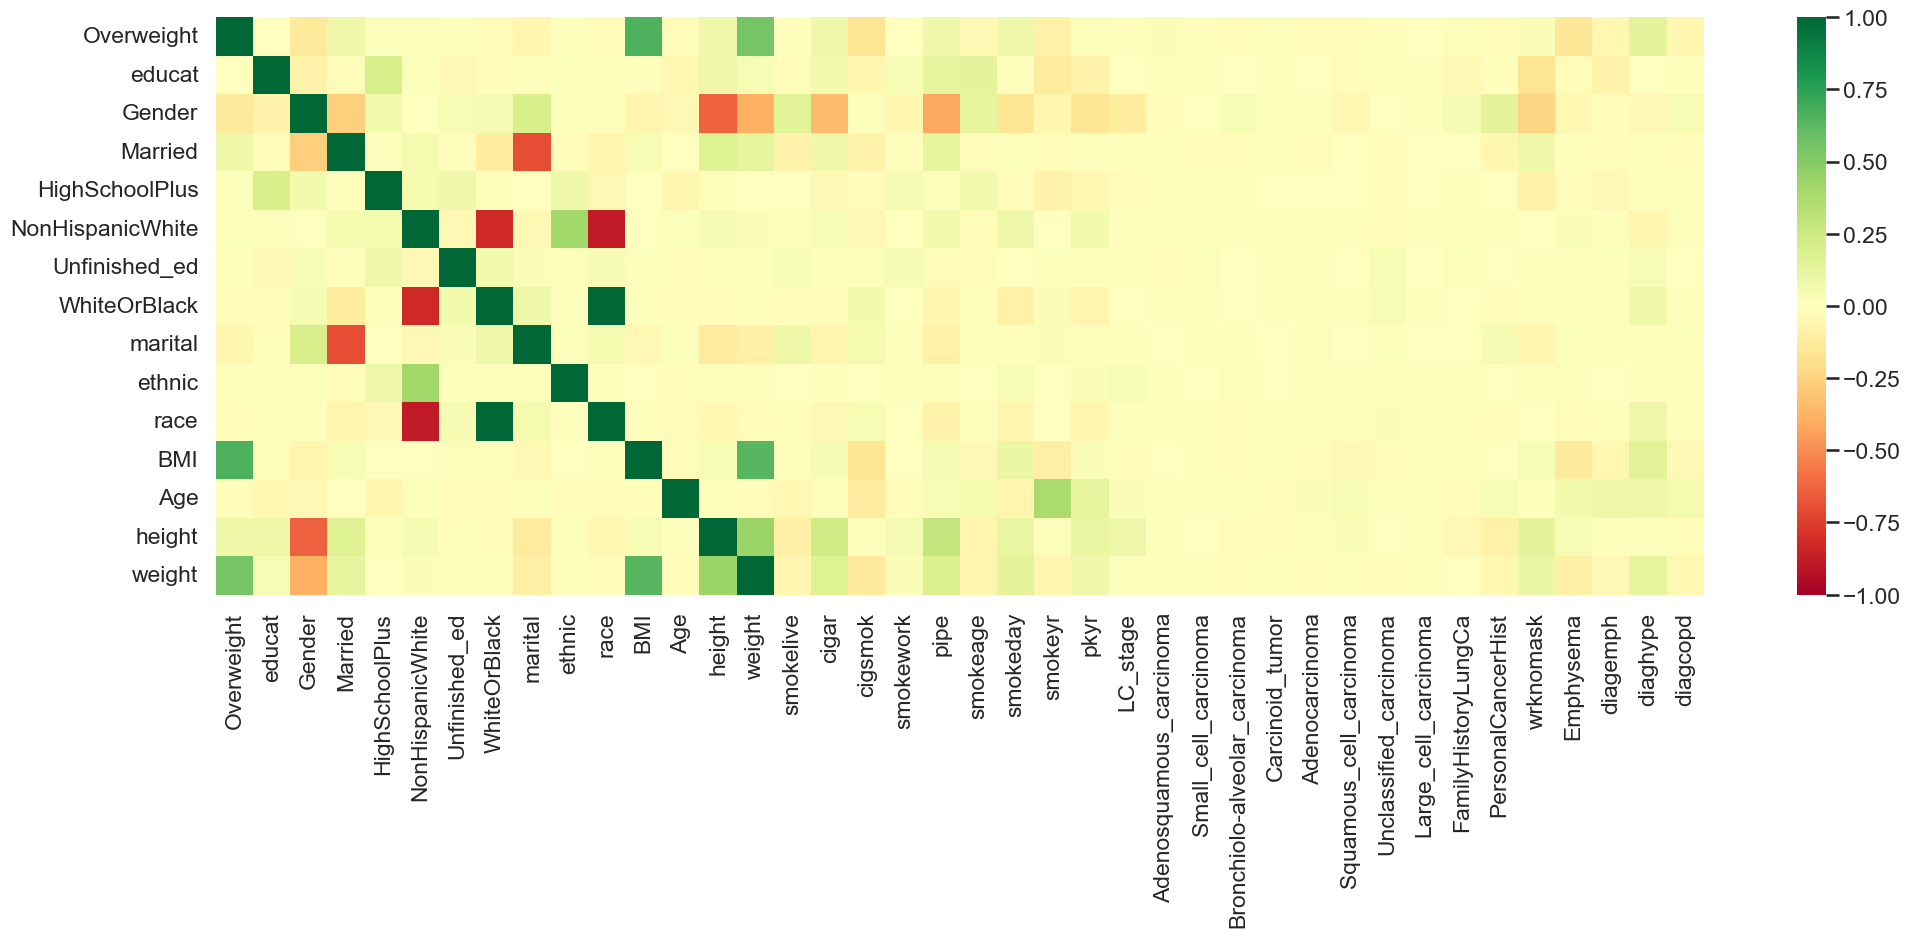

### Tijmen

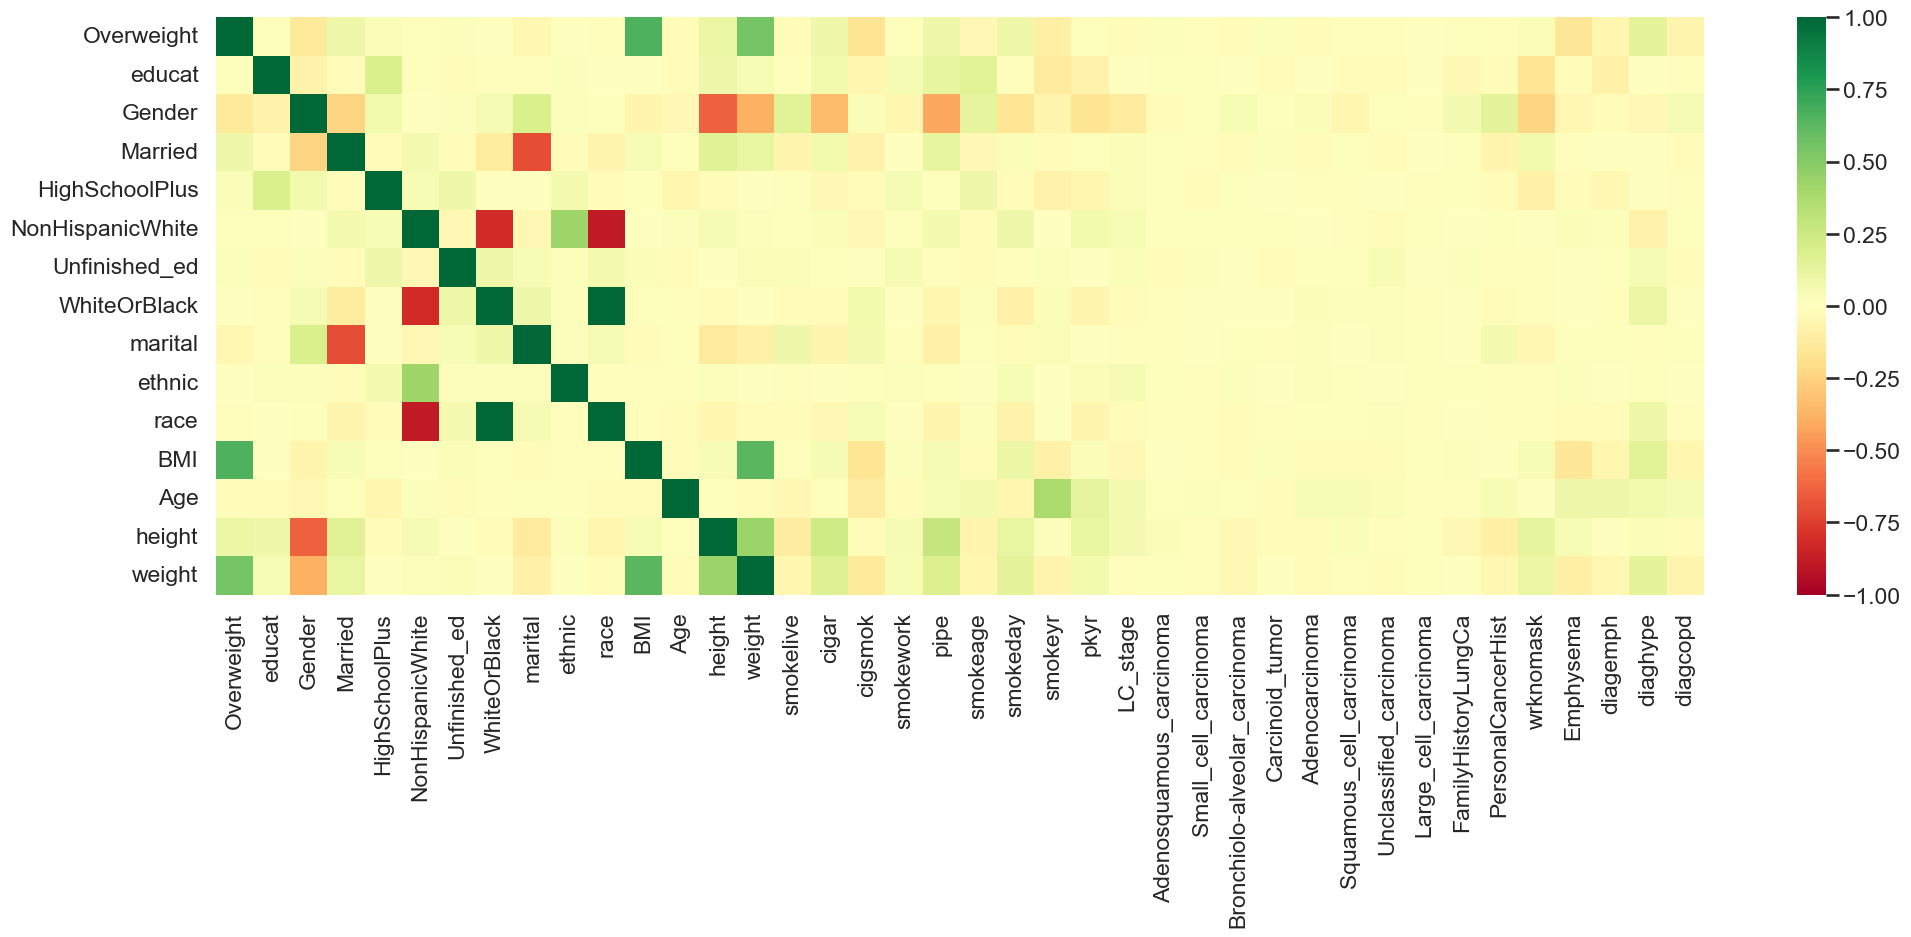

### Sybil

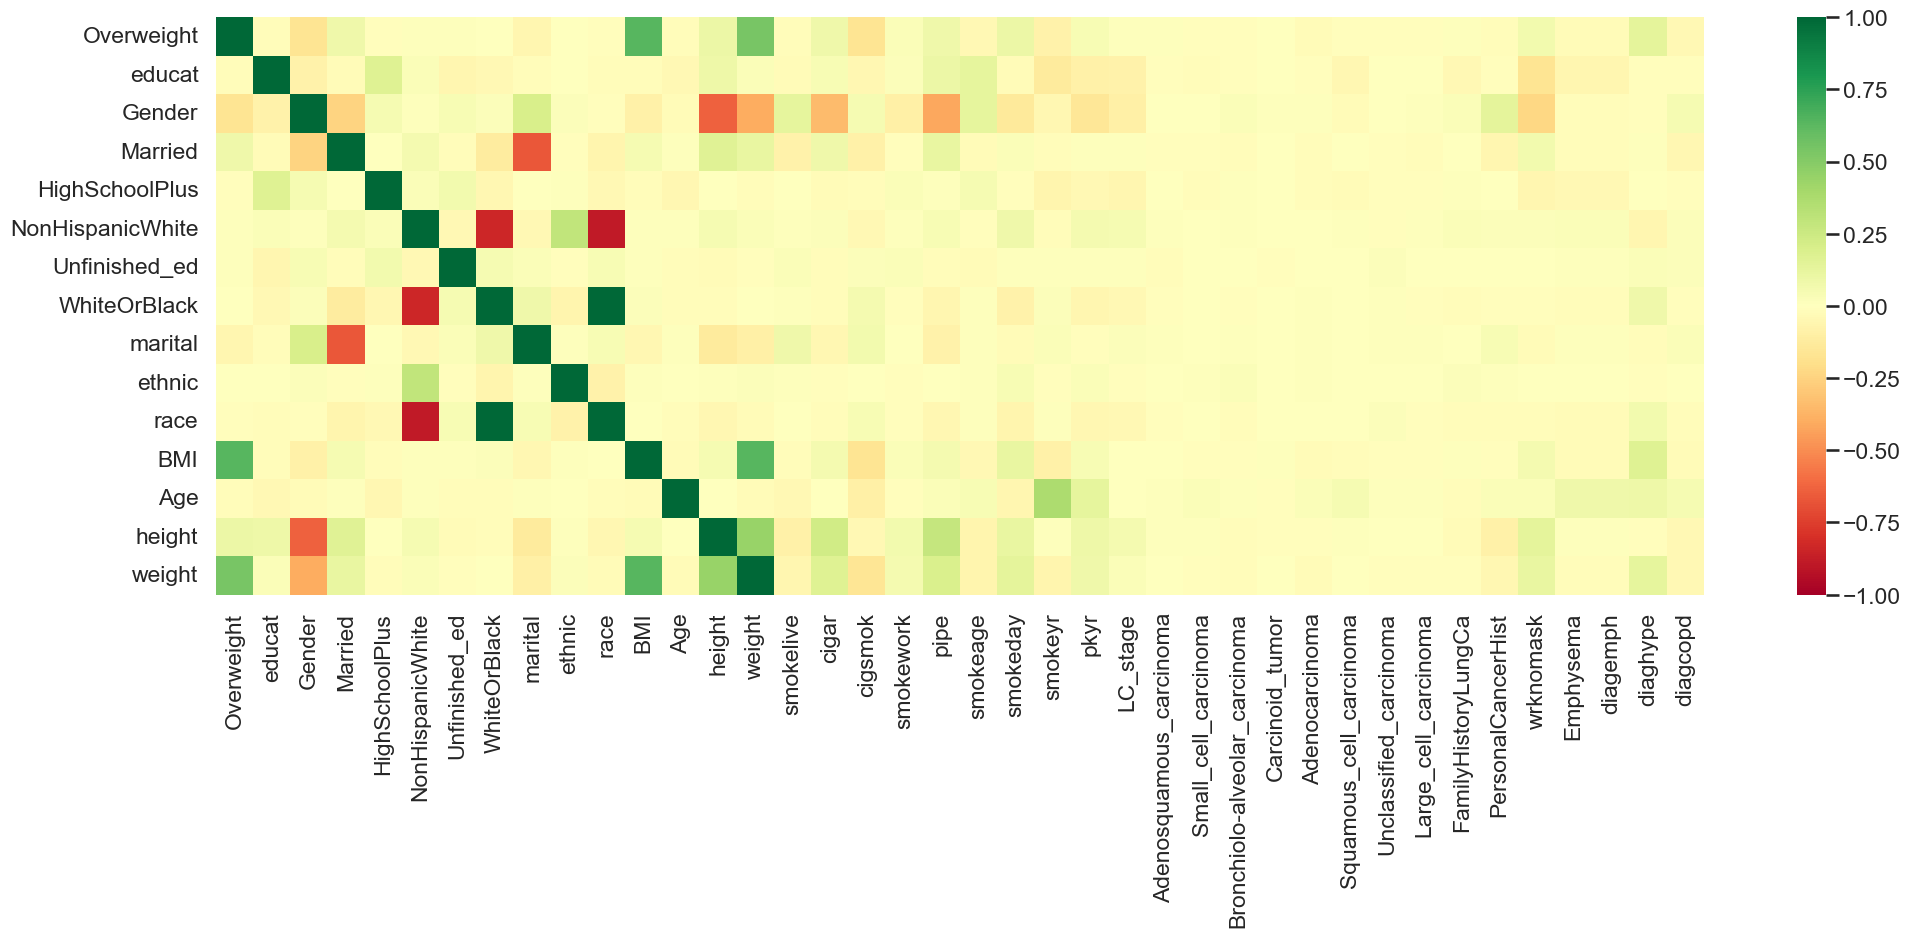

### diff_Kiran_Tijmen

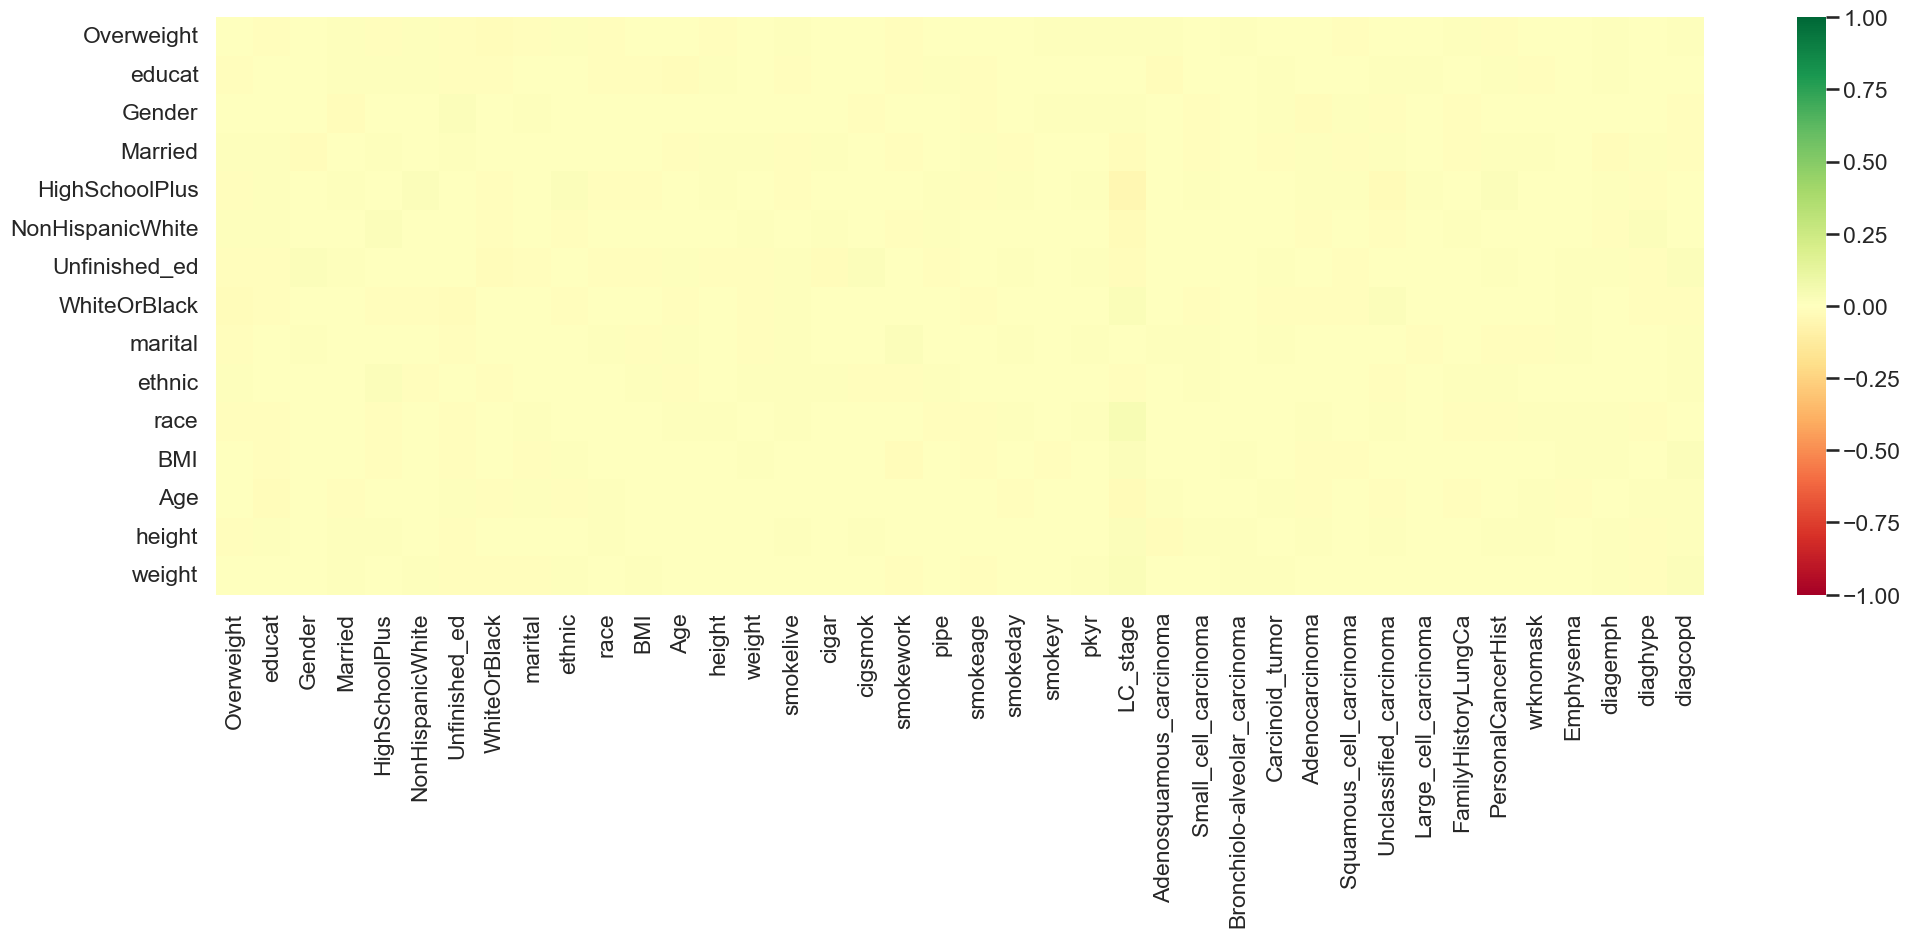

### diff_Kiran_Sybil

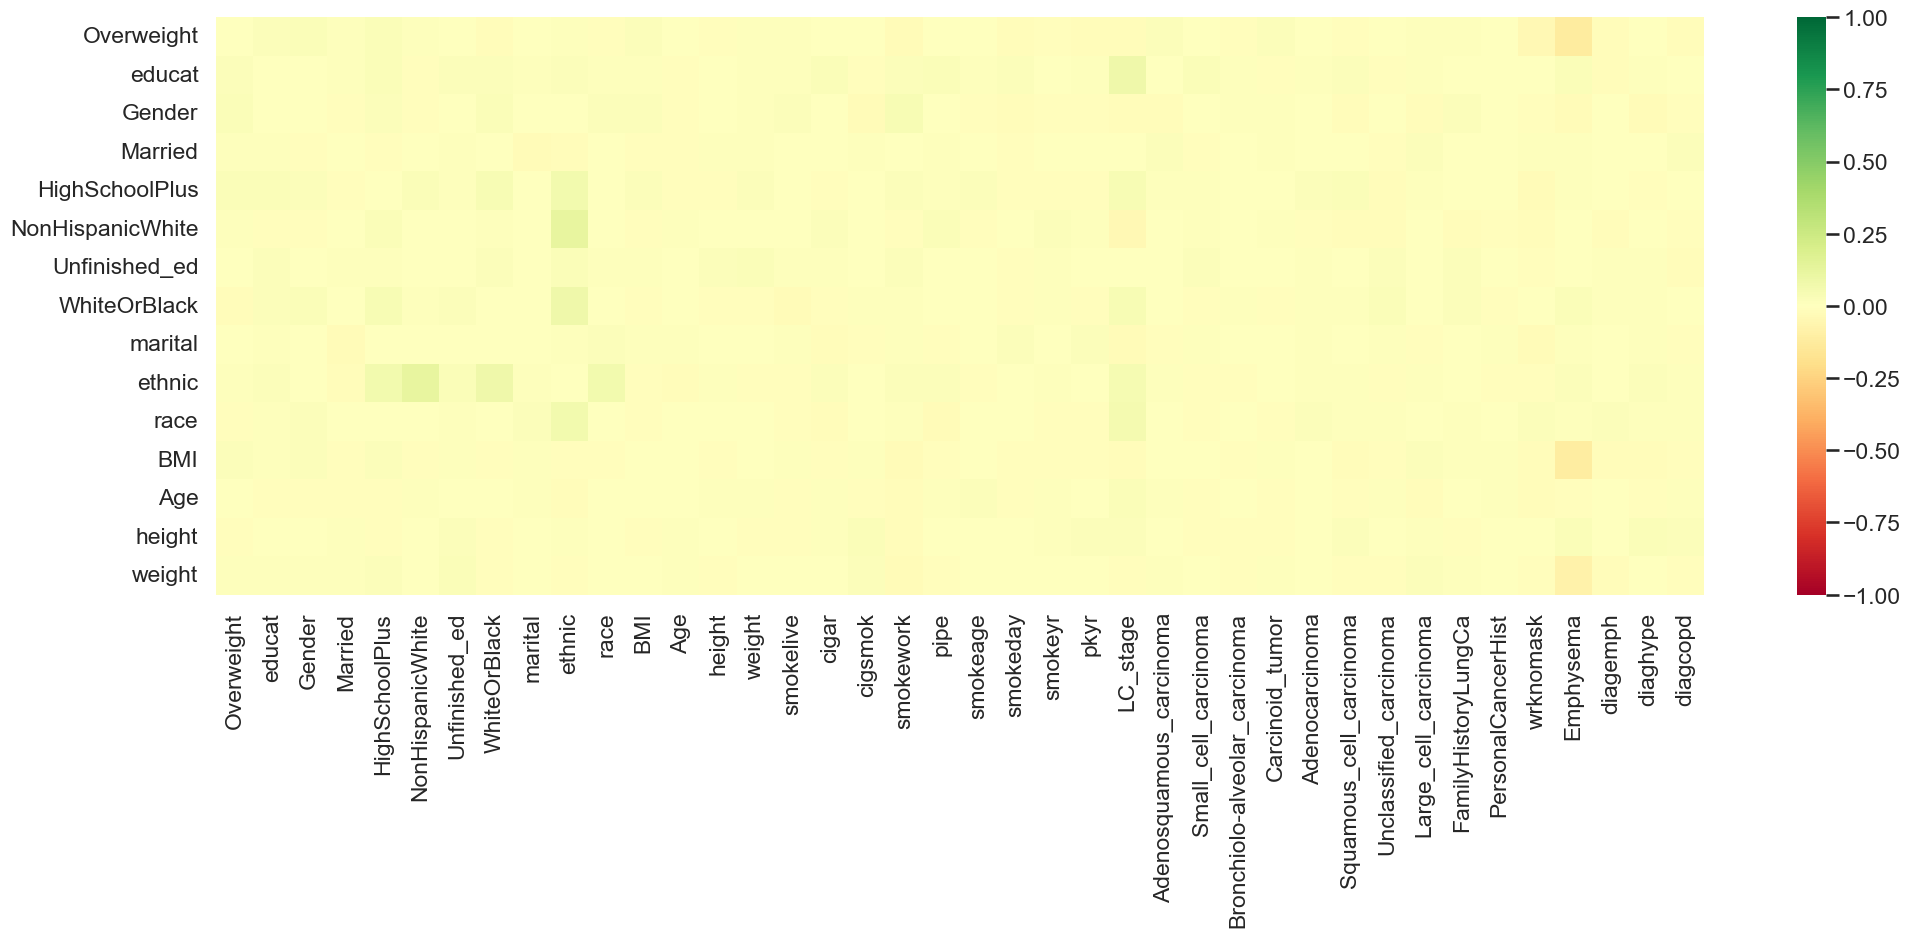

In [22]:
for m in correlations:
    corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
    corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['lungcanc'] + nlst_democols['cat']['other'] + ['diagemph', 'diaghype', 'diagcopd']
    # corr_cols, corr_rows = cols_list, cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()

## Get demo splits (validation)

In [23]:
sybil_val = sybil_demos.query('split == "dev"')
print(len(sybil_val), 'Scans')

6838 Scans


In [24]:
sybil_test = sybil_demos.query('split == "test"')
print(len(sybil_test), 'Scans')

6282 Scans


In [25]:
val_sets = {
    'Kiran': kiran_data,
    'Tijmen': tijmen_val,
    'Sybil': sybil_val,
    'Sybil_test': sybil_test
}

### Categorical columns

In [26]:
cat_demo_val = combine_col_dfs(nlst_democols['cat'], cat_dist_df, val_sets)

In [27]:
display(cat_demo_val.sort_values(by='diff_norm_Kiran_Sybil', ascending=False).head(20))
cat_demo_val.sort_values(by='diff_norm_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,Sybil_test_freq,Sybil_test_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Kiran_Sybil_test,diff_norm_Tijmen_Sybil,diff_norm_Tijmen_Sybil_test,diff_norm_Sybil_Sybil_test
206,other,Emphysema,True,3697.0,36.3056,755.0,36.6149,576.0,8.4235,484.0,7.7046,-0.3093,27.8821,28.6010,28.1914,28.9103,0.7189
200,other,FamilyHistoryLungCa,True,2622.0,25.7488,512.0,24.8303,1469.0,21.4829,1362.0,21.6810,0.9185,4.2659,4.0678,3.3474,3.1493,-0.1981
226,lungcanc,Adenocarcinoma,True,539.0,5.2931,129.0,6.2561,82.0,1.1992,107.0,1.7033,-0.9630,4.0939,3.5898,5.0569,4.5528,-0.5041
208,lungcanc,LC_stage,110.0,596.0,5.8529,138.0,6.6925,127.0,1.8573,113.0,1.7988,-0.8396,3.9956,4.0541,4.8352,4.8937,0.0585
0,demo,Overweight,False,3220.0,31.6213,667.0,32.3472,1979.0,28.9412,1930.0,30.7227,-0.7259,2.6801,0.8986,3.4060,1.6245,-1.7815
19,demo,NonHispanicWhite,True,9311.0,91.4367,1909.0,92.5800,6076.0,88.8564,5718.0,91.0220,-1.1433,2.5803,0.4147,3.7236,1.5580,-2.1656
58,smoke,cigsmok,1,5088.0,49.9656,1060.0,51.4064,3241.0,47.3969,3026.0,48.1694,-1.4408,2.5687,1.7962,4.0095,3.2370,-0.7725
22,demo,WhiteOrBlack,1.0,9461.0,92.9098,1933.0,93.7439,6201.0,90.6844,5783.0,92.0567,-0.8341,2.2254,0.8531,3.0595,1.6872,-1.3723
41,demo,race,1.0,9461.0,92.9098,1933.0,93.7439,6201.0,90.6844,5783.0,92.0567,-0.8341,2.2254,0.8531,3.0595,1.6872,-1.3723
54,smoke,cigar,0.0,8215.0,80.6737,1671.0,81.0378,5376.0,78.6195,4889.0,77.8255,-0.3641,2.0542,2.8482,2.4183,3.2123,0.7940


,category,attribute,value,Kiran_freq,Kiran_norm,Tijmen_freq,Tijmen_norm,Sybil_freq,Sybil_norm,Sybil_test_freq,Sybil_test_norm,diff_norm_Kiran_Tijmen,diff_norm_Kiran_Sybil,diff_norm_Kiran_Sybil_test,diff_norm_Tijmen_Sybil,diff_norm_Tijmen_Sybil_test,diff_norm_Sybil_Sybil_test
205,other,Emphysema,False,6486.0,63.6944,1307.0,63.3851,6256.0,91.4887,5783.0,92.0567,0.3093,-27.7943,-28.3623,-28.1036,-28.6716,-0.5680
216,lungcanc,LC_stage,NaN,9011.0,88.4906,1801.0,87.3424,6506.0,95.1448,5979.0,95.1767,1.1482,-6.6542,-6.6861,-7.8024,-7.8343,-0.0319
199,other,FamilyHistoryLungCa,False,7561.0,74.2512,1550.0,75.1697,5369.0,78.5171,4920.0,78.3190,-0.9185,-4.2659,-4.0678,-3.3474,-3.1493,0.1981
225,lungcanc,Adenocarcinoma,False,9644.0,94.7069,1933.0,93.7439,6756.0,98.8008,6175.0,98.2967,0.9630,-4.0939,-3.5898,-5.0569,-4.5528,0.5041
1,demo,Overweight,True,6963.0,68.3787,1395.0,67.6528,4859.0,71.0588,4352.0,69.2773,0.7259,-2.6801,-0.8986,-3.4060,-1.6245,1.7815
18,demo,NonHispanicWhite,False,872.0,8.5633,153.0,7.4200,762.0,11.1436,564.0,8.9780,1.1433,-2.5803,-0.4147,-3.7236,-1.5580,2.1656
57,smoke,cigsmok,0,5095.0,50.0344,1002.0,48.5936,3597.0,52.6031,3256.0,51.8306,1.4408,-2.5687,-1.7962,-4.0095,-3.2370,0.7725
55,smoke,cigar,1.0,1934.0,18.9924,384.0,18.6227,1450.0,21.2050,1376.0,21.9039,0.3697,-2.2126,-2.9115,-2.5823,-3.2812,-0.6989
119,disease,diagemph,0.0,9136.0,89.7182,1853.0,89.8642,6256.0,91.4887,5783.0,92.0567,-0.1460,-1.7705,-2.3385,-1.6245,-2.1925,-0.5680
140,disease,diagcopd,0.0,9479.0,93.0865,1916.0,92.9195,6478.0,94.7353,5930.0,94.3967,0.1670,-1.6488,-1.3102,-1.8158,-1.4772,0.3386


### Numerical columns

In [28]:
num_demo_val = combine_col_dfs(nlst_democols['num'], num_dist_df, val_sets)

In [29]:
display(num_demo_val.sort_values(by='diff_Kiran_Sybil', ascending=False).head(20))
num_demo_val.sort_values(by='diff_Kiran_Sybil', ascending=True).head(20)

,category,attribute,value,Kiran,Tijmen,Sybil,Sybil_test,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Kiran_Sybil_test,diff_Tijmen_Sybil,diff_Tijmen_Sybil_test,diff_Sybil_Sybil_test
14,smoke,pkyr,50%,50.0000,51.0000,48.0000,49.5000,-1.0000,2.0000,0.5000,3.0000,1.5000,-1.5000
3,demo,Age,mean,63.2049,63.3225,61.6000,61.5807,-0.1176,1.6049,1.6242,1.7225,1.7418,0.0193
15,smoke,pkyr,mean,57.9729,58.0242,56.4101,57.2229,-0.0513,1.5628,0.7500,1.6141,0.8013,-0.8128
13,smoke,smokeyr,mean,41.0055,41.0887,39.8867,40.1227,-0.0832,1.1188,0.8828,1.2020,0.9660,-0.2360
12,smoke,smokeyr,50%,41.0000,41.0000,40.0000,40.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000
2,demo,Age,50%,62.0000,63.0000,61.0000,61.0000,-1.0000,1.0000,1.0000,2.0000,2.0000,0.0000
5,demo,height,mean,67.8867,67.9452,67.8172,67.9108,-0.0585,0.0695,-0.0241,0.1280,0.0344,-0.0936
11,smoke,smokeday,mean,28.5740,28.6906,28.5390,28.9032,-0.1166,0.0350,-0.3292,0.1516,-0.2126,-0.3642
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,category,attribute,value,Kiran,Tijmen,Sybil,Sybil_test,diff_Kiran_Tijmen,diff_Kiran_Sybil,diff_Kiran_Sybil_test,diff_Tijmen_Sybil,diff_Tijmen_Sybil_test,diff_Sybil_Sybil_test
7,demo,weight,mean,181.8113,181.5927,183.6606,183.6864,0.2186,-1.8493,-1.8751,-2.0679,-2.0937,-0.0258
1,demo,BMI,mean,27.6277,27.5492,27.9667,27.8674,0.0785,-0.3390,-0.2397,-0.4175,-0.3182,0.0993
0,demo,BMI,50%,27.0197,26.9151,27.3167,27.0927,0.1046,-0.2970,-0.0730,-0.4016,-0.1776,0.2240
9,smoke,smokeage,mean,16.5991,16.5984,16.7151,16.6479,0.0007,-0.1160,-0.0488,-0.1167,-0.0495,0.0672
6,demo,weight,50%,180.0000,178.0000,180.0000,180.0000,2.0000,0.0000,0.0000,-2.0000,-2.0000,0.0000
10,smoke,smokeday,50%,25.0000,25.0000,25.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
11,smoke,smokeday,mean,28.5740,28.6906,28.5390,28.9032,-0.1166,0.0350,-0.3292,0.1516,-0.2126,-0.3642
5,demo,height,mean,67.8867,67.9452,67.8172,67.9108,-0.0585,0.0695,-0.0241,0.1280,0.0344,-0.0936


### Demographic correlations

In [30]:
correlations = {m: val_sets[m][cols_list].corr(method='kendall').round(2) for m in val_sets}
corr0 = correlations.copy()    
for i, m1 in enumerate(corr0):
    for j, m2 in enumerate(corr0):
        if j > i:
            correlations[f"diff_{m1}_{m2}"] = correlations[f"{m1}"] - correlations[f"{m2}"]

### Kiran

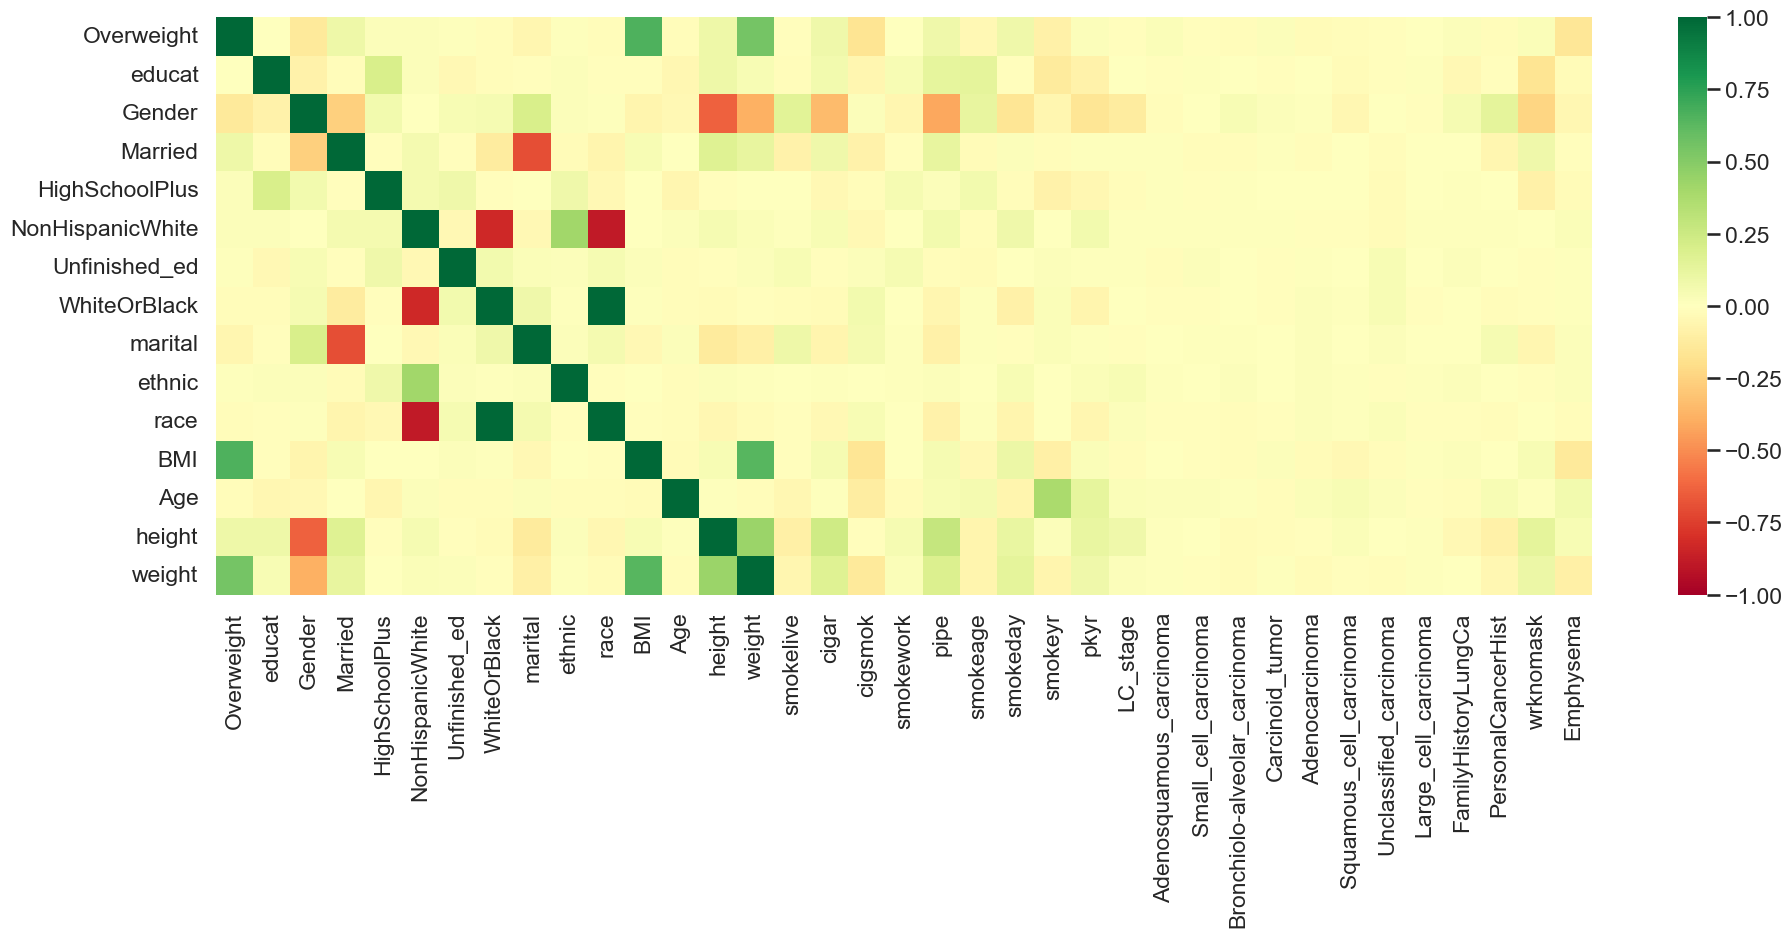

### Tijmen

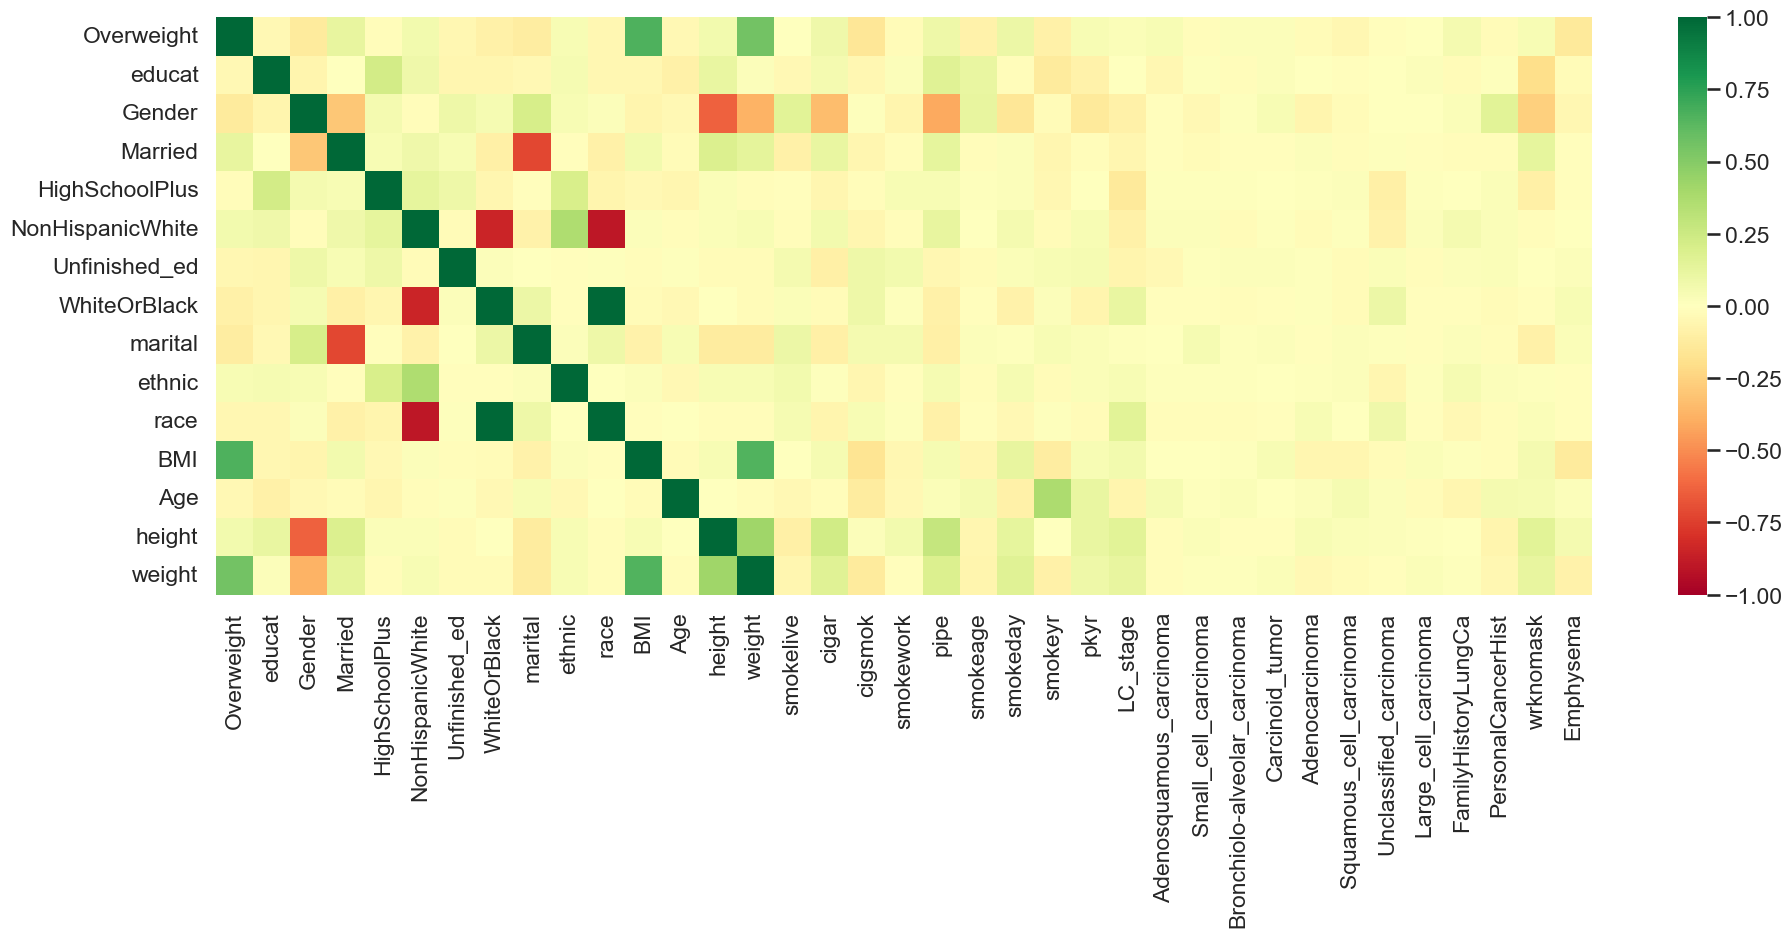

### Sybil

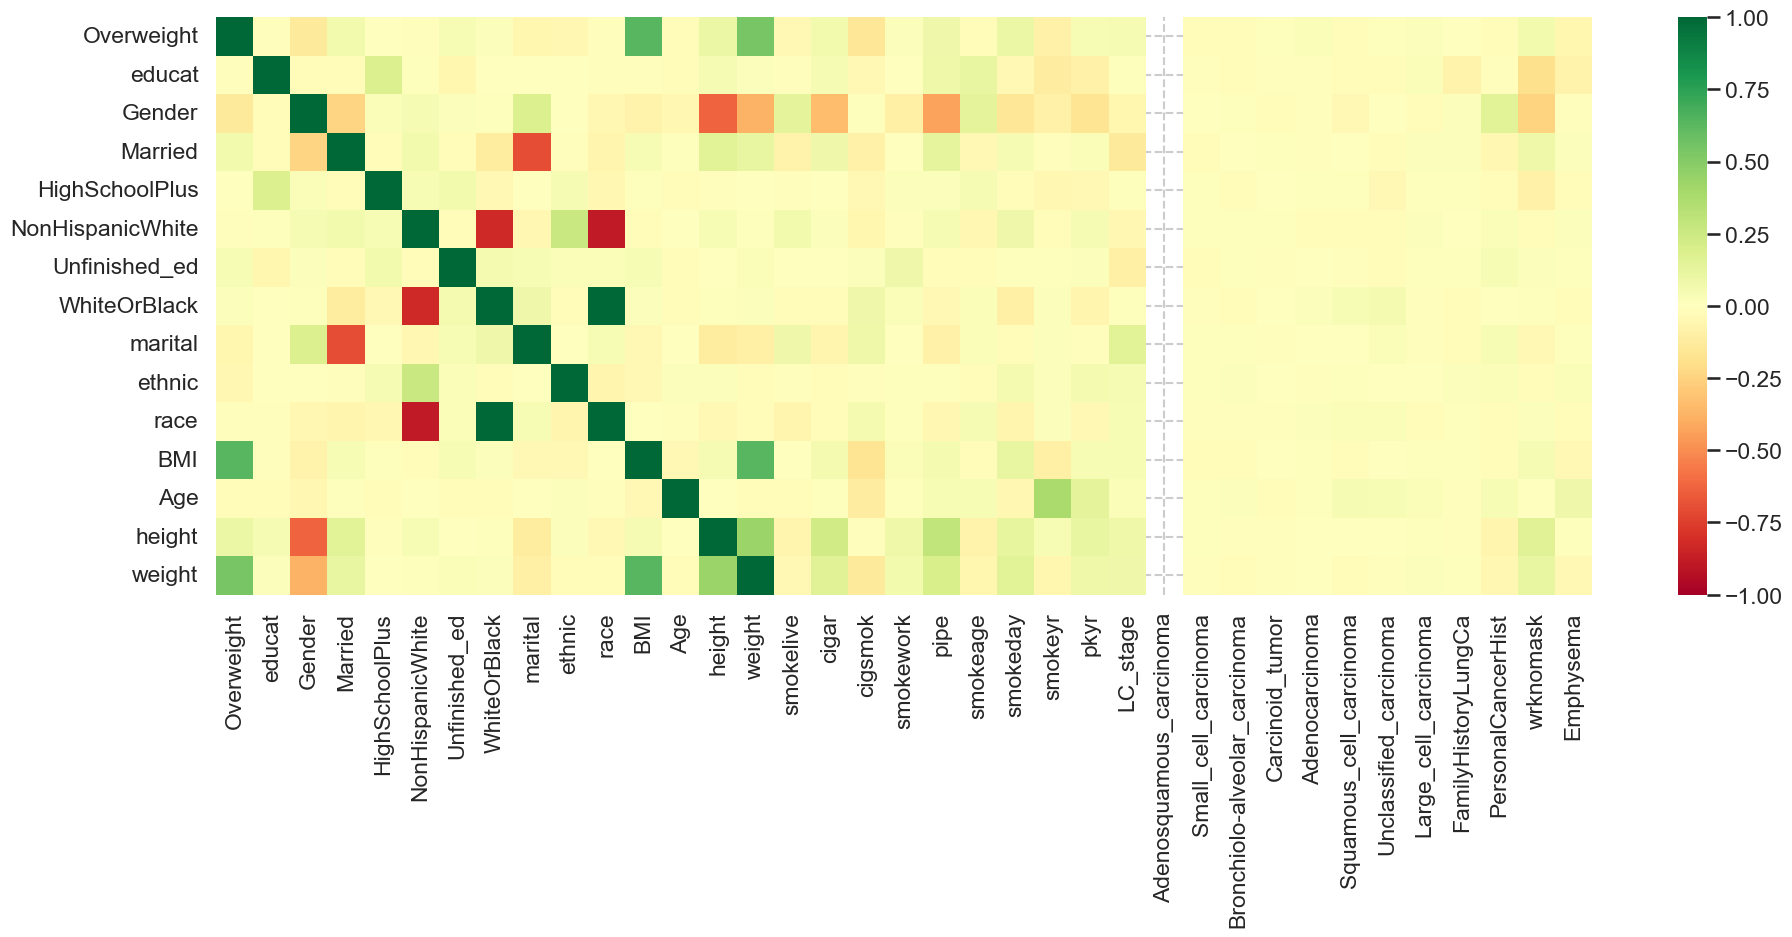

### Sybil_test

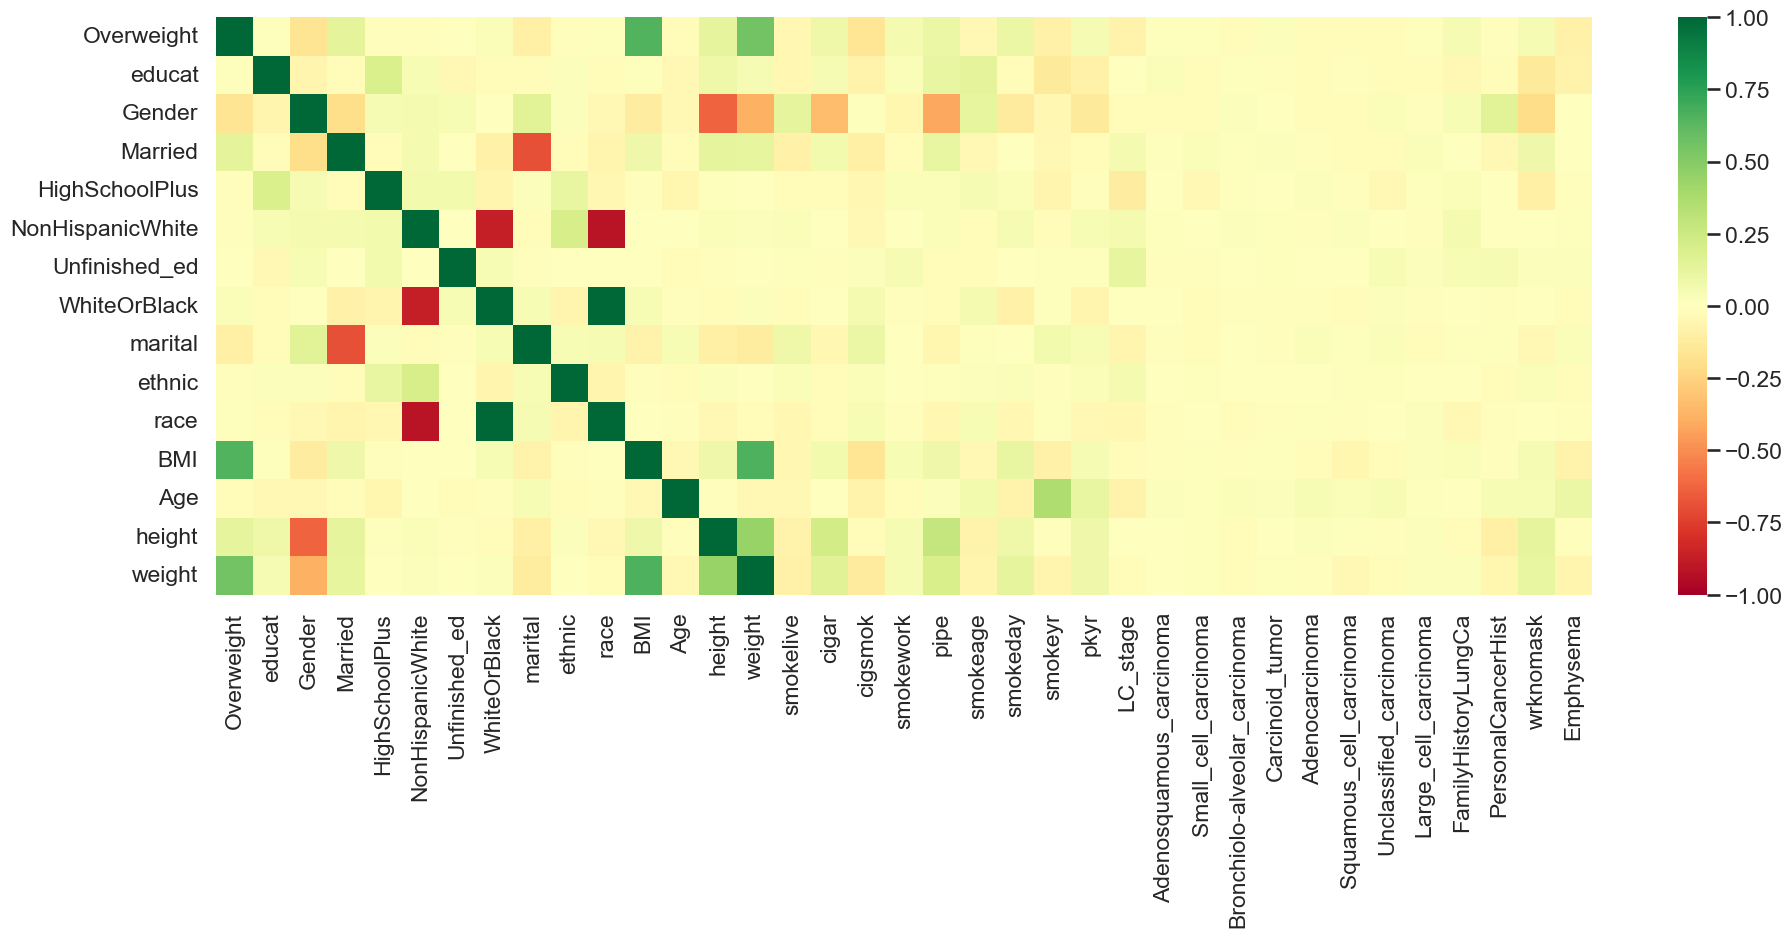

### diff_Kiran_Tijmen

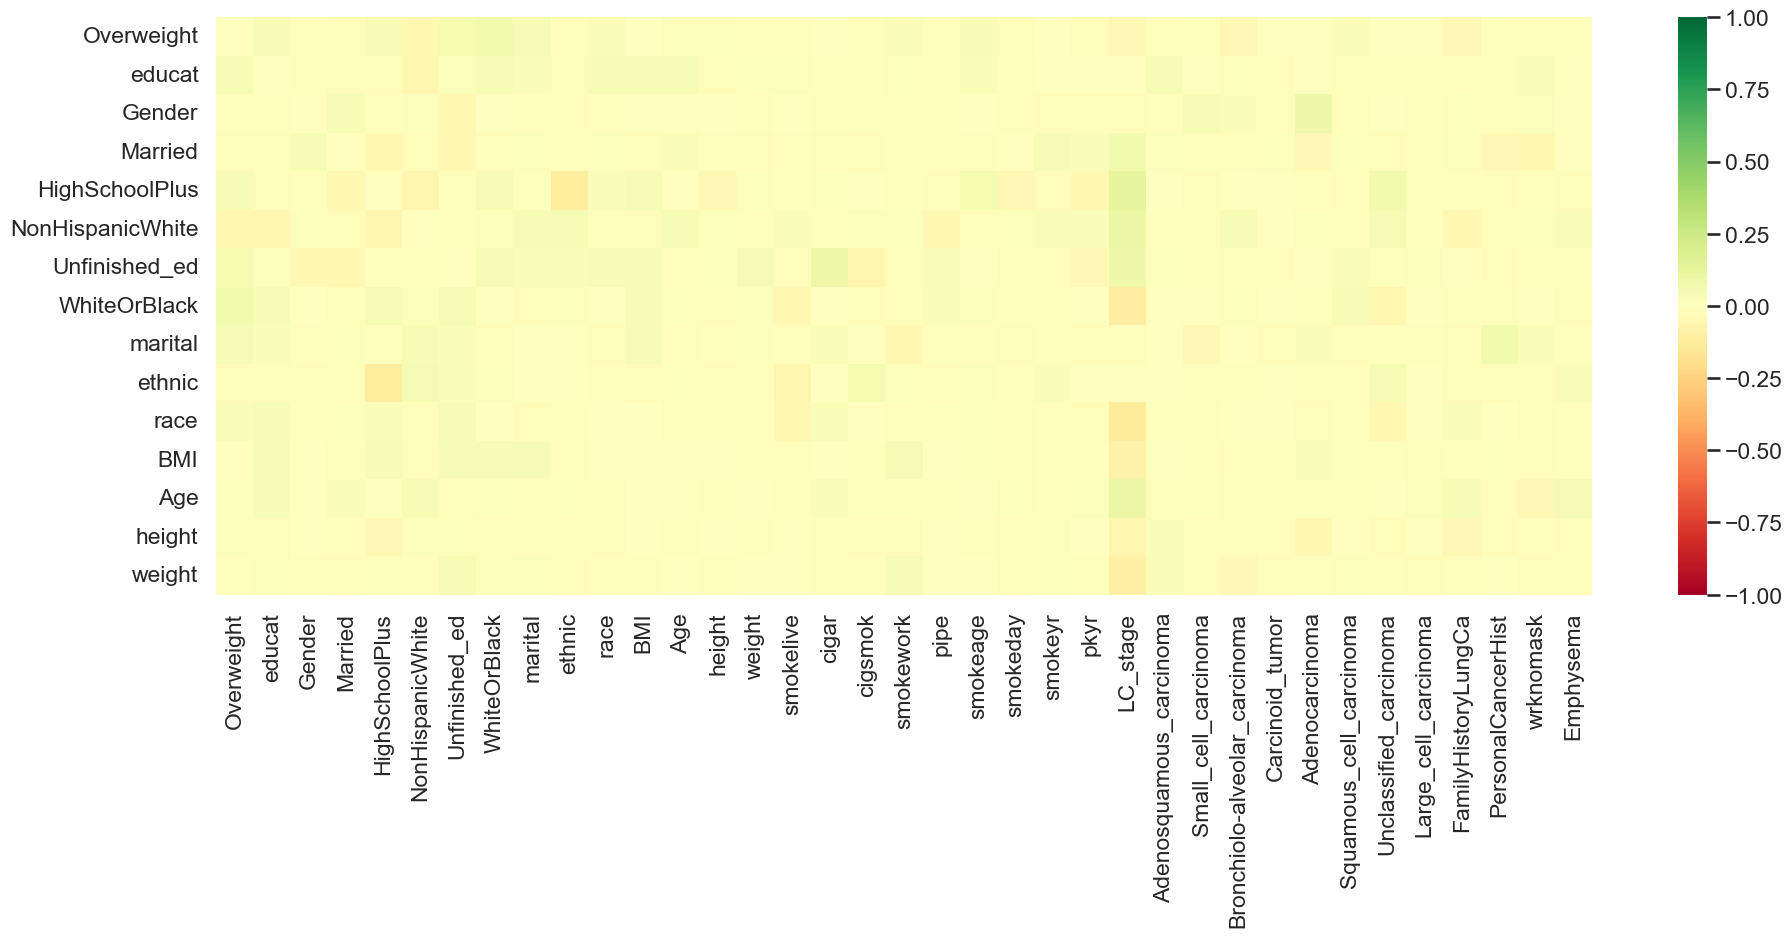

### diff_Kiran_Sybil

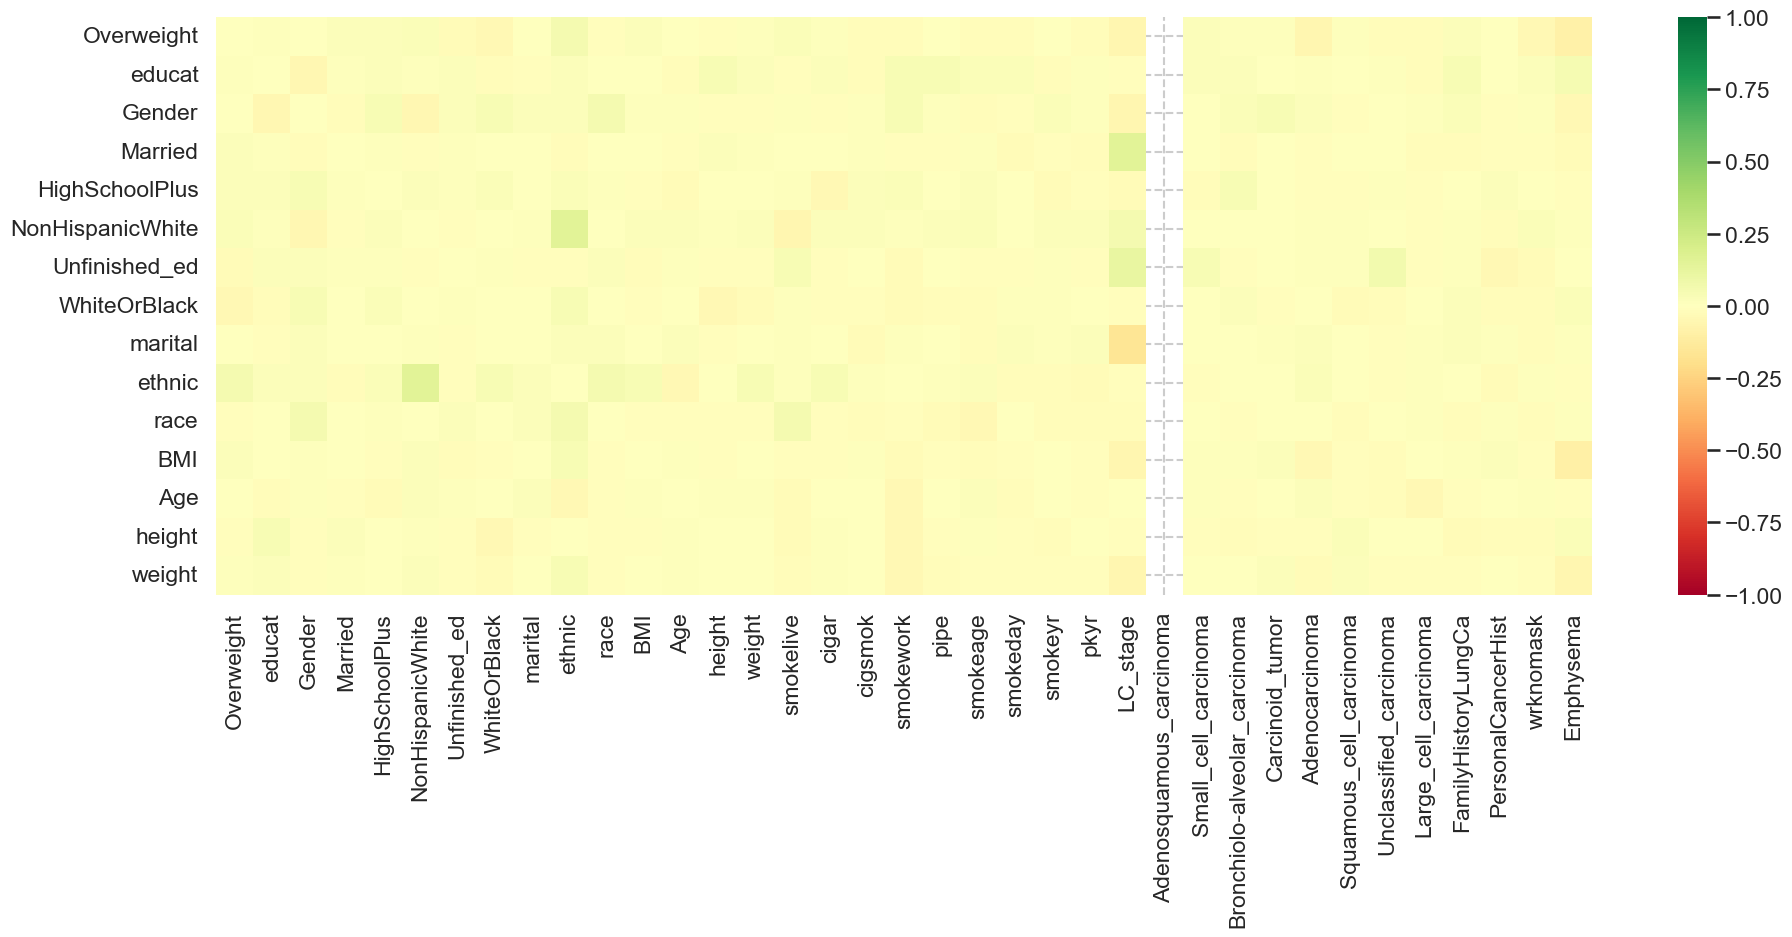

### diff_Kiran_Sybil_test

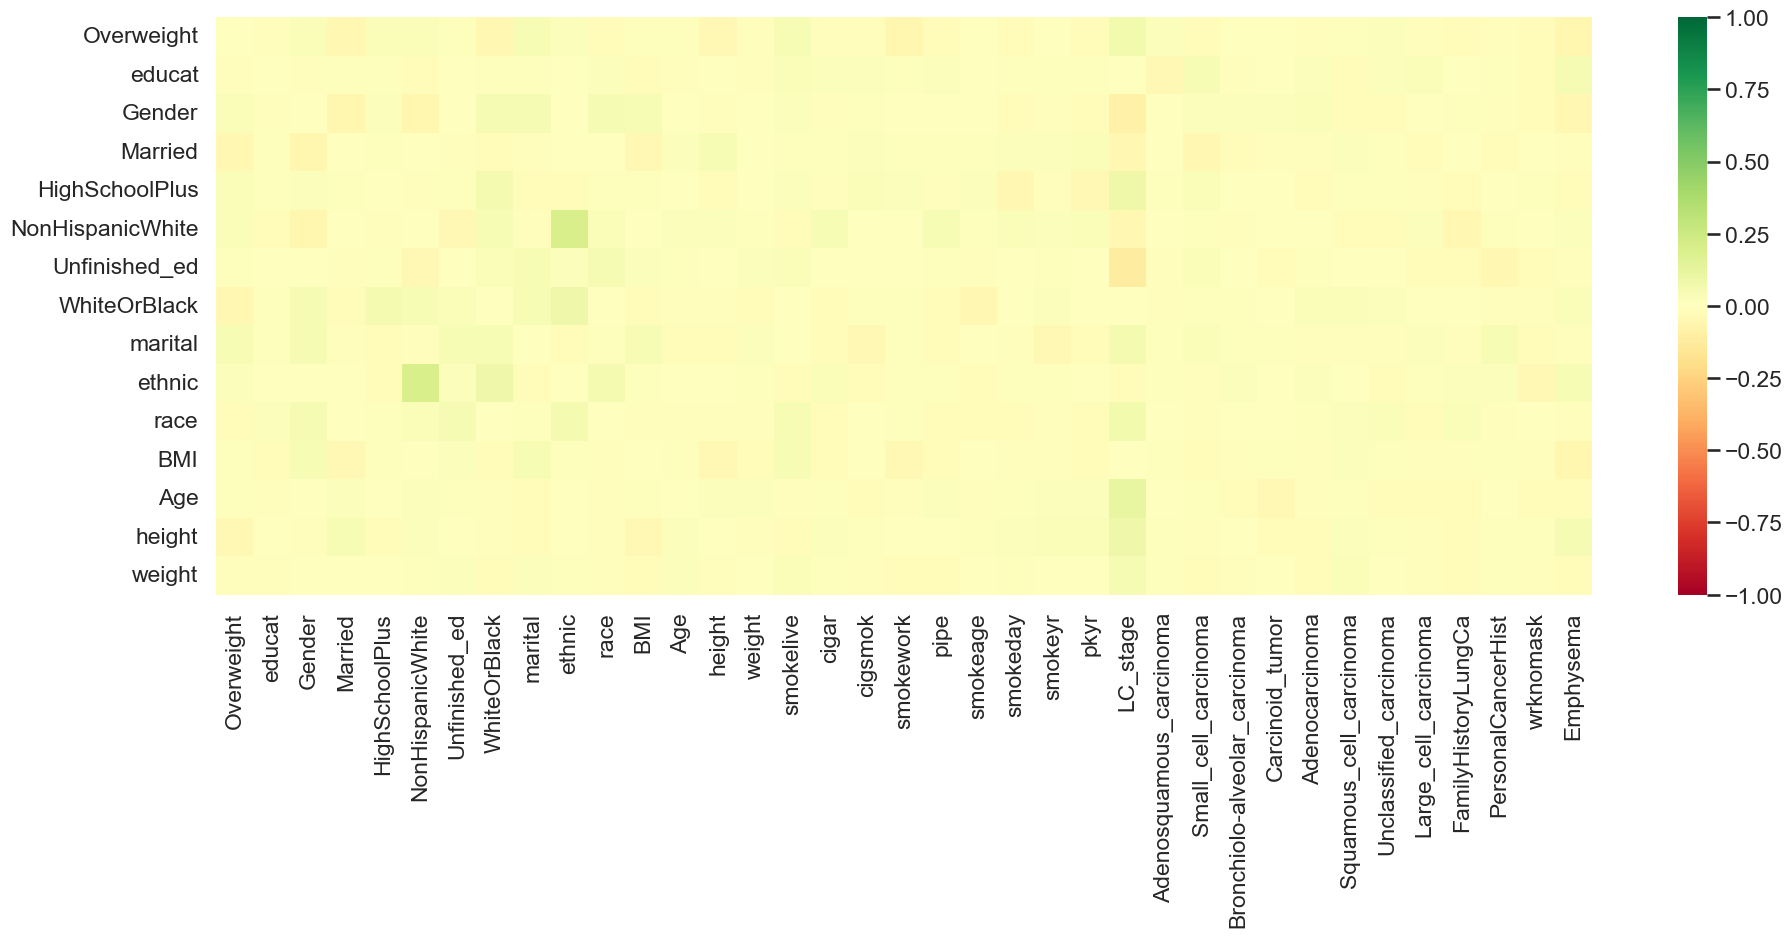

### diff_Tijmen_Sybil

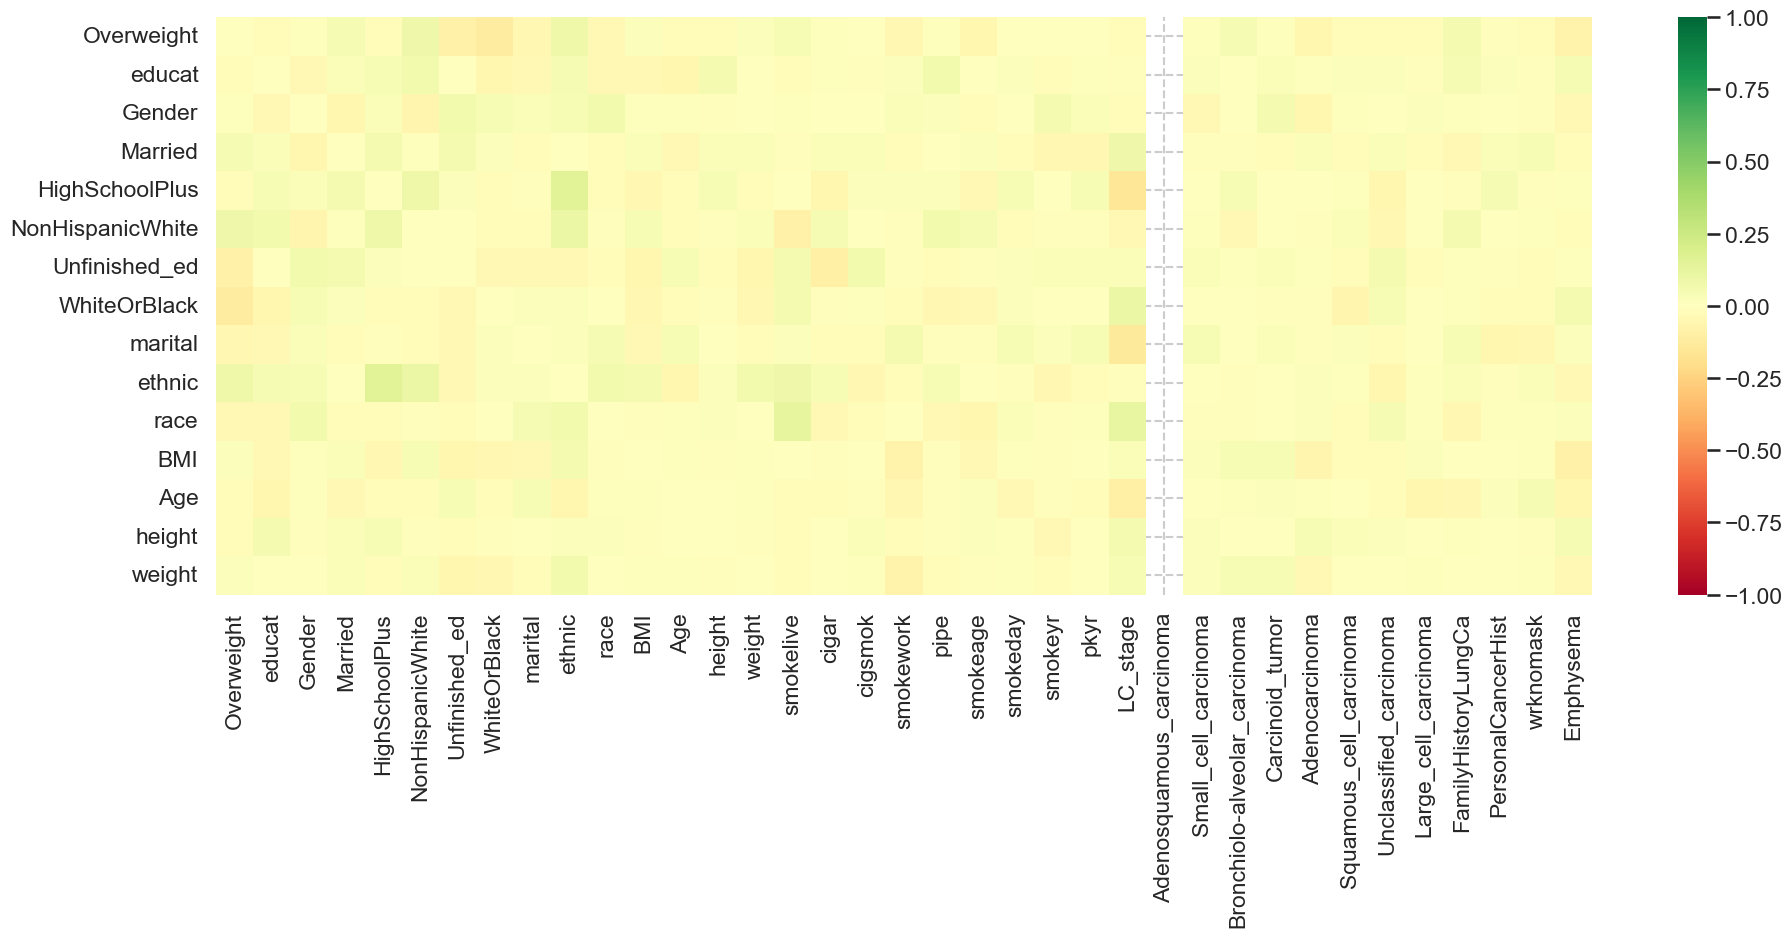

### diff_Tijmen_Sybil_test

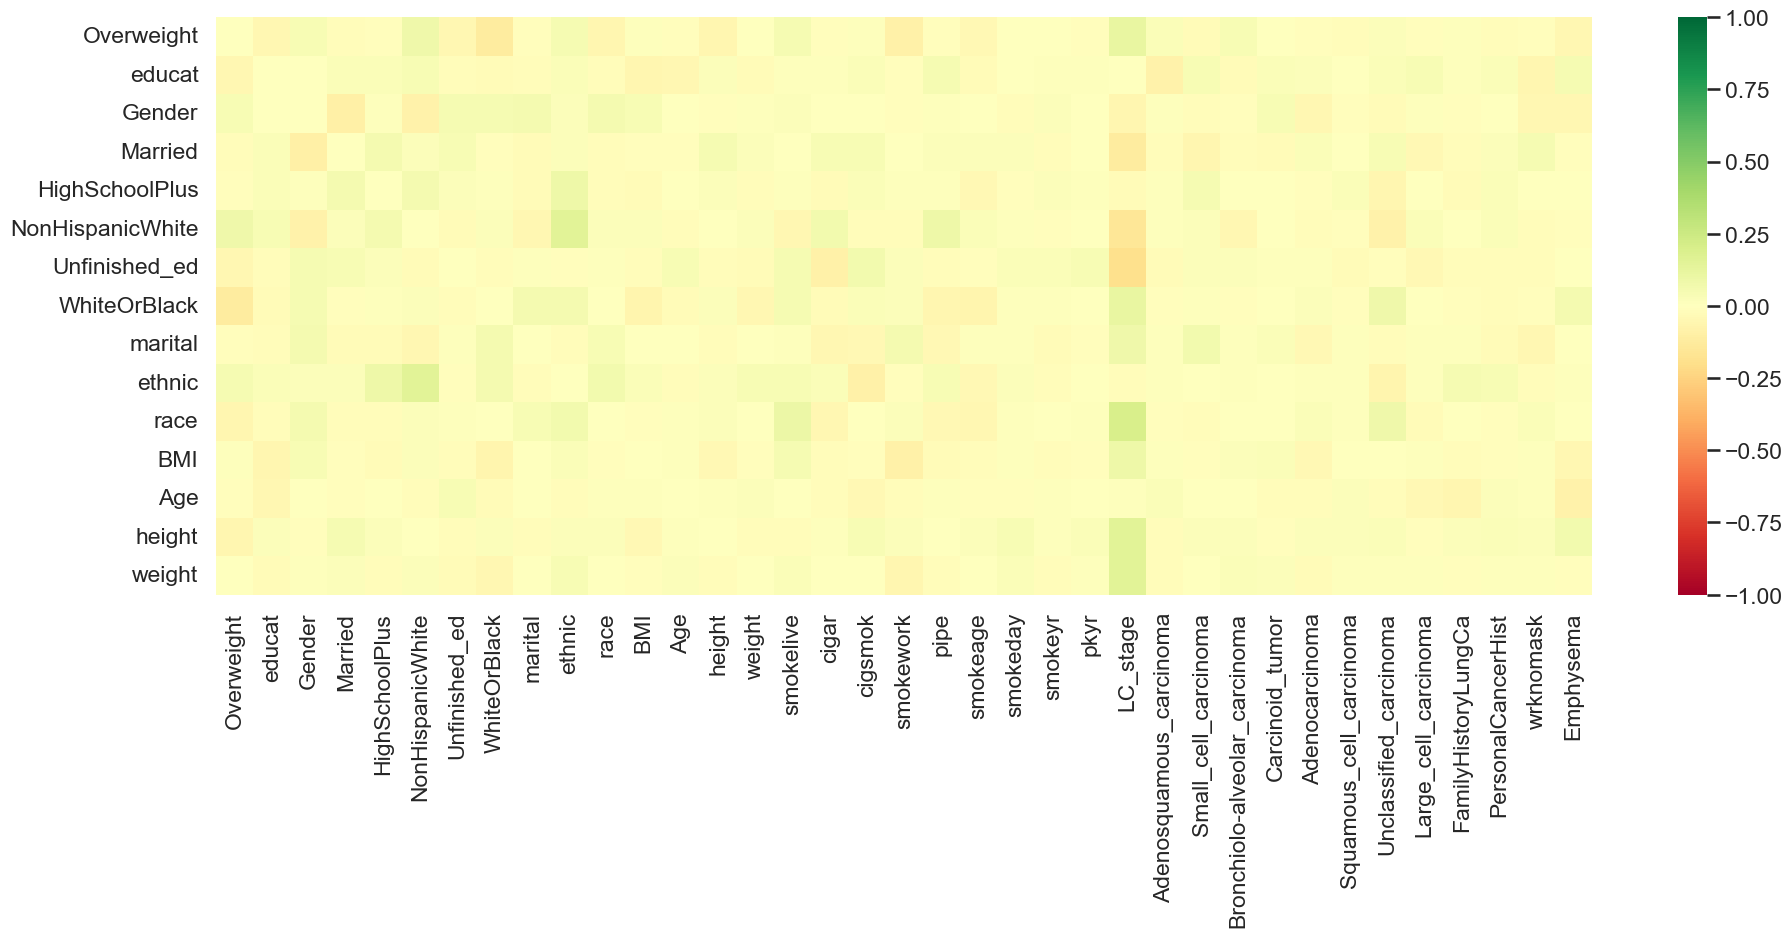

### diff_Sybil_Sybil_test

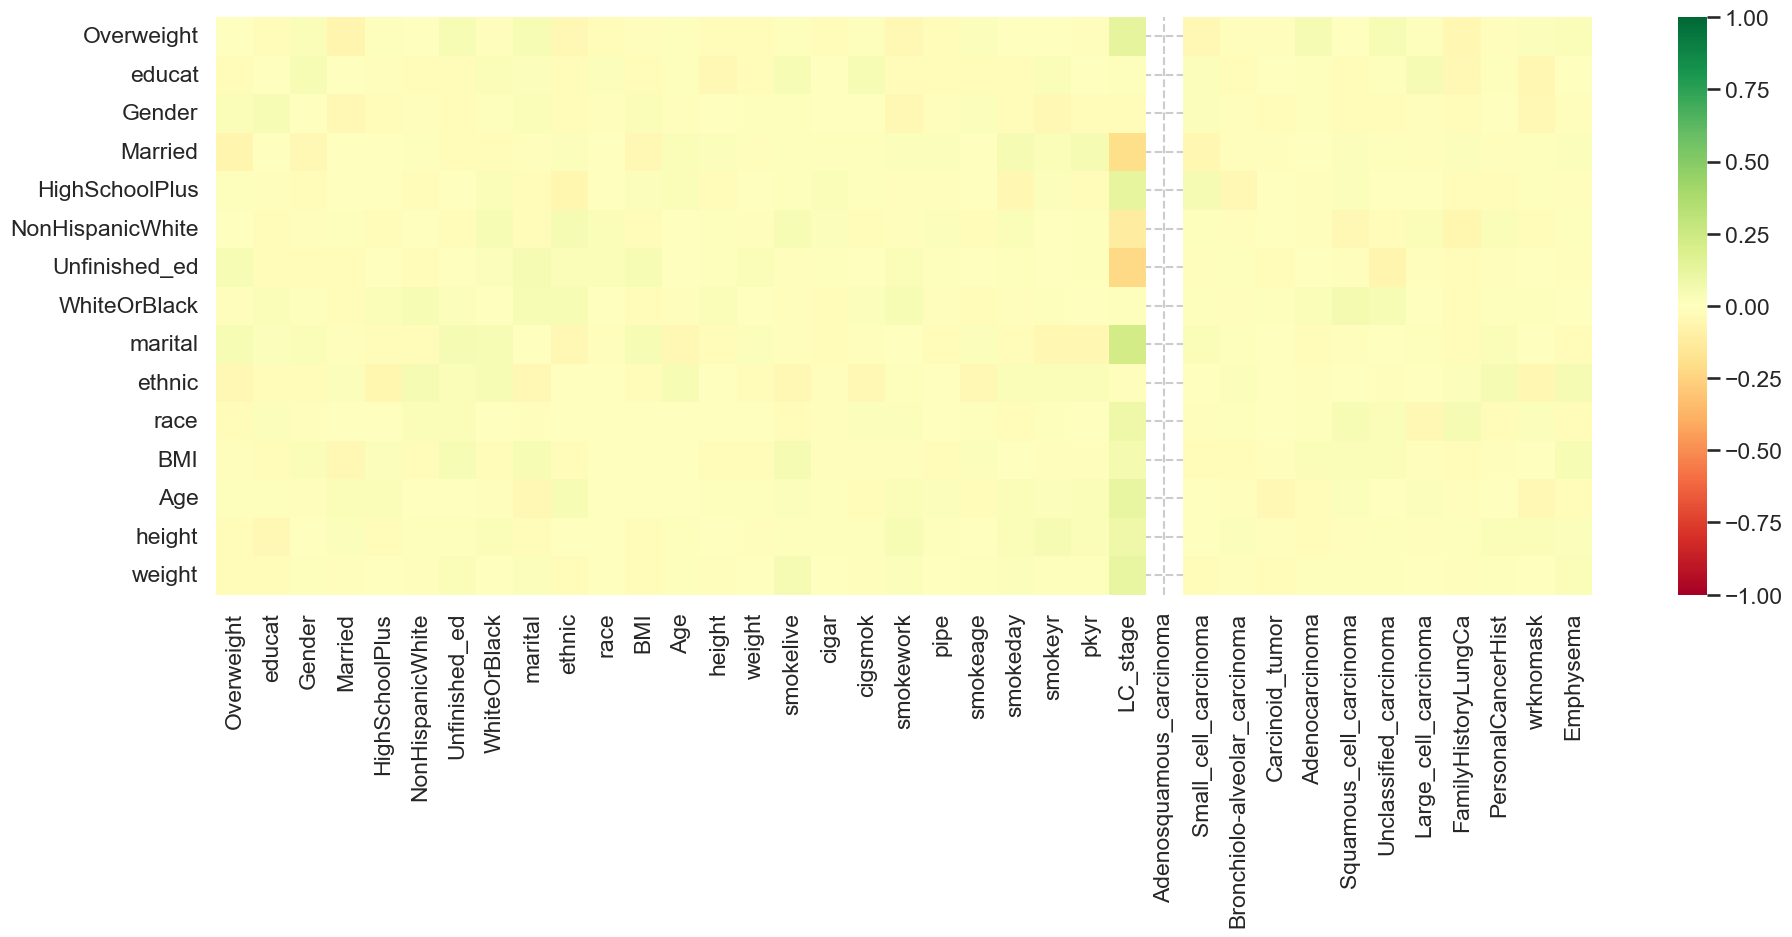

In [31]:
for m in correlations:
    corr_rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
    corr_cols = corr_rows + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke'] + nlst_democols['cat']['lungcanc'] + nlst_democols['cat']['other']
    # corr_cols = cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()

## What about when Sybil is worse?

In [32]:
sybil_worse_df = pd.read_csv(f"{NLST_PREDS}/sybil_worse.csv")
sybil_worse_df

,col,sym,val
0,wrknomask,=,True
1,FamilyHistoryLungCa,=,True
2,Emphysema,=,True
3,Gender,=,1
4,Married,=,True
5,wrkasbe,=,1
6,wrkfoun,=,1
7,diagadas,=,1
8,diagcopd,=,1
9,diagpneu,=,1


In [33]:
rows = nlst_democols['cat']['demo'] + nlst_democols['num']['demo']
cols = rows + list(set(list(sybil_worse_df['col'])) - set(['NoduleCounts', 'Diameter [mm]'] + rows)) + nlst_democols['cat']['smoke'] + nlst_democols['num']['smoke']
cols

['Overweight',
 'educat',
 'Gender',
 'Married',
 'HighSchoolPlus',
 'NonHispanicWhite',
 'Unfinished_ed',
 'WhiteOrBlack',
 'marital',
 'ethnic',
 'race',
 'BMI',
 'Age',
 'height',
 'weight',
 'FamilyHistoryLungCa',
 'wrknomask',
 'diagpneu',
 'wrkfoun',
 'Emphysema',
 'diagcopd',
 'diagadas',
 'wrkasbe',
 'smokelive',
 'cigar',
 'cigsmok',
 'smokework',
 'pipe',
 'smokeage',
 'smokeday',
 'smokeyr',
 'pkyr']

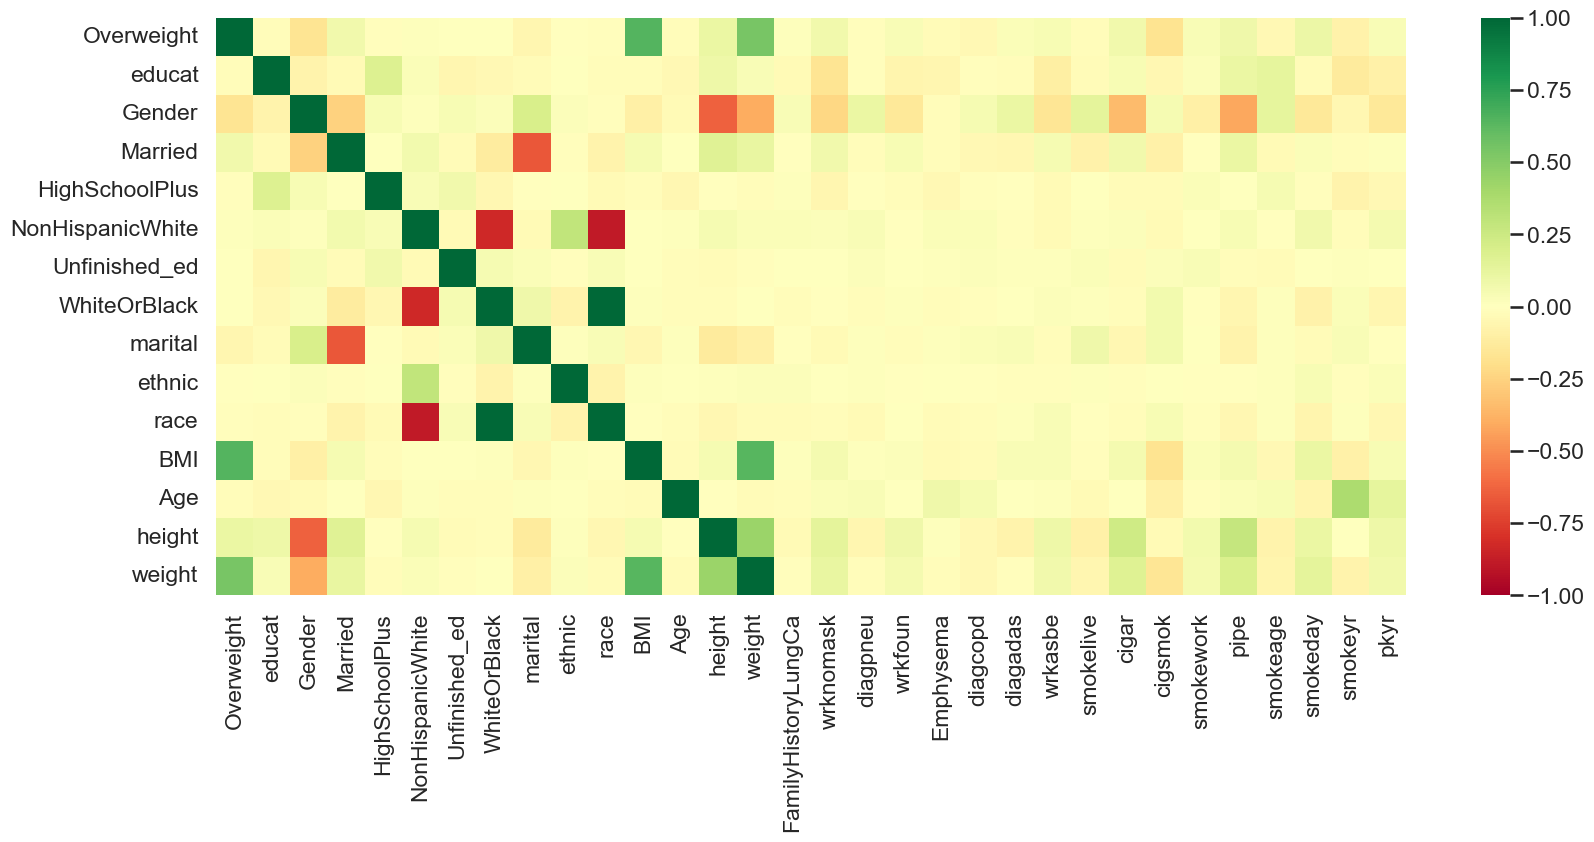

,race,cigsmok,Unfinished_ed,educat,Emphysema,WhiteOrBlack,HighSchoolPlus,smokelive,FamilyHistoryLungCa,smokework,...,diagadas,wrkasbe,ethnic,pkyr,marital,diagpneu,wrkfoun,diagcopd,smokeyr,weight
race,1.000000,0.039360,0.036196,-0.018311,-0.029675,1.000000,-0.036721,-0.001969,-0.023562,-0.009814,...,0.013360,0.032343,-0.075429,-0.054337,0.038875,-0.037056,0.007378,-0.019882,0.008061,-0.026367
cigsmok,0.039360,1.000000,0.017876,-0.052603,-0.008502,0.064639,-0.023776,0.043412,-0.001270,-0.020851,...,-0.047162,-0.012443,0.004059,0.011465,0.067821,-0.007785,0.004853,-0.004379,0.322401,-0.161055
Unfinished_ed,0.036196,0.017876,1.000000,-0.061747,0.012966,0.049658,0.070431,0.028575,0.002478,0.034118,...,0.010209,0.010459,-0.007885,0.007056,0.030850,0.022175,0.002108,0.017095,0.008514,-0.009130
educat,-0.018311,-0.052603,-0.061747,1.000000,-0.062256,-0.041934,0.174002,-0.026097,-0.038899,0.015658,...,-0.020018,-0.101622,0.002466,-0.089467,-0.023681,-0.008381,-0.069858,-0.012834,-0.126854,0.033181
Emphysema,-0.029675,-0.008502,0.012966,-0.062256,1.000000,-0.017553,-0.041702,-0.007614,0.038543,0.038872,...,0.137929,0.023504,0.001514,0.102358,0.012337,0.082046,0.041367,0.282179,0.099996,-0.023246
WhiteOrBlack,1.000000,0.064639,0.049658,-0.041934,-0.017553,1.000000,-0.051398,0.011274,-0.016805,-0.005380,...,0.003778,0.017934,-0.070584,-0.058065,0.078859,-0.023200,0.014485,-0.010859,0.024733,0.003777
HighSchoolPlus,-0.036721,-0.023776,0.070431,0.174002,-0.041702,-0.051398,1.000000,0.004299,0.011626,0.028662,...,-0.004373,-0.033846,0.006567,-0.044074,-0.003906,-0.003992,-0.018281,-0.010915,-0.070452,-0.020216
smokelive,-0.001969,0.043412,0.028575,-0.026097,-0.007614,0.011274,0.004299,1.000000,0.055987,0.128898,...,0.029077,-0.002208,0.008608,0.017178,0.083967,0.037191,-0.000231,0.007670,0.016817,-0.060805
FamilyHistoryLungCa,-0.023562,-0.001270,0.002478,-0.038899,0.038543,-0.016805,0.011626,0.055987,1.000000,0.024663,...,0.007449,0.022625,0.016260,0.015394,-0.000968,0.023591,-0.000401,0.012679,-0.003203,-0.011029
smokework,-0.009814,-0.020851,0.034118,0.015658,0.038872,-0.005380,0.028662,0.128898,0.024663,1.000000,...,0.007401,0.037270,-0.006082,0.061600,0.001619,0.035986,0.035638,0.032058,0.004558,0.056559


In [34]:
utils.corrmat(sybil_train, rows, cols)

## Population shift for train and val?

### Sybil

In [35]:
sybil_sets = {
    "train":sybil_train,
    "val":sybil_val,
    "test":sybil_test,
    "eval":kiran_data
}

In [36]:
cat_demo_shift = combine_col_dfs(nlst_democols['cat'], cat_dist_df, sybil_sets).query('value != 0')
display(cat_demo_shift.sort_values(by='diff_norm_train_eval', ascending=False).head(20))
cat_demo_shift.sort_values(by='diff_norm_train_eval', ascending=True).head(20)

,category,attribute,value,train_freq,train_norm,val_freq,val_norm,test_freq,test_norm,eval_freq,eval_norm,diff_norm_train_val,diff_norm_train_test,diff_norm_train_eval,diff_norm_val_test,diff_norm_val_eval,diff_norm_test_eval
219,lungcanc,LC_stage,NaN,26725.0,94.9041,6506.0,95.1448,5979.0,95.1767,9011.0,88.4906,-0.2407,-0.2726,6.4135,-0.0319,6.6542,6.6861
1,demo,Overweight,True,19898.0,70.6605,4859.0,71.0588,4352.0,69.2773,6963.0,68.3787,-0.3983,1.3832,2.2818,1.7815,2.6801,0.8986
57,smoke,cigar,1.0,5942.0,21.1009,1450.0,21.2050,1376.0,21.9039,1934.0,18.9924,-0.1041,-0.8030,2.1085,-0.6989,2.2126,2.9115
7,demo,educat,6.0,4836.0,17.1733,1177.0,17.2126,1008.0,16.0458,1585.0,15.5652,-0.0393,1.1275,1.6081,1.1668,1.6474,0.4806
12,demo,Gender,1,16572.0,58.8494,4016.0,58.7306,3769.0,59.9968,5834.0,57.2916,0.1188,-1.1474,1.5578,-1.2662,1.4390,2.7052
15,demo,Married,True,19282.0,68.4730,4628.0,67.6806,4295.0,68.3699,6855.0,67.3181,0.7924,0.1031,1.1549,-0.6893,0.3625,1.0518
30,demo,marital,2.0,19282.0,68.4730,4628.0,67.6806,4295.0,68.3699,6855.0,67.3181,0.7924,0.1031,1.1549,-0.6893,0.3625,1.0518
6,demo,educat,5.0,6647.0,23.6044,1521.0,22.2433,1394.0,22.1904,2287.0,22.4590,1.3611,1.4140,1.1454,0.0529,-0.2157,-0.2686
65,smoke,pipe,1.0,6429.0,22.8303,1584.0,23.1647,1508.0,24.0051,2221.0,21.8109,-0.3344,-1.1748,1.0194,-0.8404,1.3538,2.1942
21,demo,Unfinished_ed,True,7912.0,28.0966,1801.0,26.3381,1658.0,26.3929,2805.0,27.5459,1.7585,1.7037,0.5507,-0.0548,-1.2078,-1.1530


,category,attribute,value,train_freq,train_norm,val_freq,val_norm,test_freq,test_norm,eval_freq,eval_norm,diff_norm_train_val,diff_norm_train_test,diff_norm_train_eval,diff_norm_val_test,diff_norm_val_eval,diff_norm_test_eval
209,other,Emphysema,1.0,2317.0,8.2280,576.0,8.4235,484.0,7.7046,3697.0,36.3056,-0.1955,0.5234,-28.0776,0.7189,-27.8821,-28.6010
211,lungcanc,LC_stage,110.0,549.0,1.9496,127.0,1.8573,113.0,1.7988,596.0,5.8529,0.0923,0.1508,-3.9033,0.0585,-3.9956,-4.0541
203,other,FamilyHistoryLungCa,True,6232.0,22.1307,1469.0,21.4829,1362.0,21.6810,2622.0,25.7488,0.6478,0.4497,-3.6181,-0.1981,-4.2659,-4.0678
229,lungcanc,Adenocarcinoma,True,558.0,1.9815,82.0,1.1992,107.0,1.7033,539.0,5.2931,0.7823,0.2782,-3.3116,-0.5041,-4.0939,-3.5898
60,smoke,cigsmok,1,13386.0,47.5355,3241.0,47.3969,3026.0,48.1694,5088.0,49.9656,0.1386,-0.6339,-2.4301,-0.7725,-2.5687,-1.7962
122,disease,diagemph,1.0,2317.0,8.2280,576.0,8.4235,484.0,7.7046,1022.0,10.0363,-0.1955,0.5234,-1.8083,0.7189,-1.6128,-2.3317
13,demo,Gender,2,11588.0,41.1506,2822.0,41.2694,2513.0,40.0032,4349.0,42.7084,-0.1188,1.1474,-1.5578,1.2662,-1.4390,-2.7052
4,demo,educat,3.0,6581.0,23.3700,1682.0,24.5978,1571.0,25.0080,2538.0,24.9239,-1.2278,-1.6380,-1.5539,-0.4102,-0.3261,0.0841
143,disease,diagcopd,1.0,1477.0,5.2450,345.0,5.0453,334.0,5.3168,676.0,6.6385,0.1997,-0.0718,-1.3935,-0.2715,-1.5932,-1.3217
225,lungcanc,Bronchiolo-alveolar_carcinoma,True,123.0,0.4368,59.0,0.8628,20.0,0.3184,180.0,1.7677,-0.4260,0.1184,-1.3309,0.5444,-0.9049,-1.4493


In [37]:
num_demo_shift = combine_col_dfs(nlst_democols['num'], num_dist_df, sybil_sets)
display(num_demo_shift.sort_values(by='diff_train_eval', ascending=False).head(20))
num_demo_shift.sort_values(by='diff_train_eval', ascending=True).head(20)

,category,attribute,value,train,val,test,eval,diff_train_val,diff_train_test,diff_train_eval,diff_val_test,diff_val_eval,diff_test_eval
7,demo,weight,mean,183.4129,183.6606,183.6864,181.8113,-0.2477,-0.2735,1.6016,-0.0258,1.8493,1.8751
1,demo,BMI,mean,27.8681,27.9667,27.8674,27.6277,-0.0986,0.0007,0.2404,0.0993,0.3390,0.2397
0,demo,BMI,50%,27.2592,27.3167,27.0927,27.0197,-0.0575,0.1665,0.2395,0.2240,0.2970,0.0730
9,smoke,smokeage,mean,16.7199,16.7151,16.6479,16.5991,0.0048,0.0720,0.1208,0.0672,0.1160,0.0488
6,demo,weight,50%,180.0000,180.0000,180.0000,180.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
10,smoke,smokeday,50%,25.0000,25.0000,25.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,demo,height,mean,67.8808,67.8172,67.9108,67.8867,0.0636,-0.0300,-0.0059,-0.0936,-0.0695,0.0241
11,smoke,smokeday,mean,28.4474,28.5390,28.9032,28.5740,-0.0916,-0.4558,-0.1266,-0.3642,-0.0350,0.3292


,category,attribute,value,train,val,test,eval,diff_train_val,diff_train_test,diff_train_eval,diff_val_test,diff_val_eval,diff_test_eval
15,smoke,pkyr,mean,56.1487,56.4101,57.2229,57.9729,-0.2614,-1.0742,-1.8242,-0.8128,-1.5628,-0.7500
3,demo,Age,mean,61.6496,61.6000,61.5807,63.2049,0.0496,0.0689,-1.5553,0.0193,-1.6049,-1.6242
13,smoke,smokeyr,mean,39.9523,39.8867,40.1227,41.0055,0.0656,-0.1704,-1.0532,-0.2360,-1.1188,-0.8828
2,demo,Age,50%,61.0000,61.0000,61.0000,62.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,-1.0000
12,smoke,smokeyr,50%,40.0000,40.0000,40.0000,41.0000,0.0000,0.0000,-1.0000,0.0000,-1.0000,-1.0000
14,smoke,pkyr,50%,49.0000,48.0000,49.5000,50.0000,1.0000,-0.5000,-1.0000,-1.5000,-2.0000,-0.5000
11,smoke,smokeday,mean,28.4474,28.5390,28.9032,28.5740,-0.0916,-0.4558,-0.1266,-0.3642,-0.0350,0.3292
5,demo,height,mean,67.8808,67.8172,67.9108,67.8867,0.0636,-0.0300,-0.0059,-0.0936,-0.0695,0.0241
4,demo,height,50%,68.0000,68.0000,68.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,smoke,smokeage,50%,16.0000,16.0000,16.0000,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Conclusion: not much demographic shift (1-2% overall not much, really). Besides family history.

### NLST vs. DLCST

In [38]:
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [39]:
dlcst_preds['Gender'] = dlcst_preds['Sex']
dlcst_preds['NoduleCounts'] = dlcst_preds['NoduleCountPerScan']
dlcst_democols = {'cat': {'all': ['Gender', 'FamilyHistoryLungCa', 'Emphysema']}, 'num': {'all': ['Age', 'NoduleCounts']}}

In [40]:
dlcst_preds['Emphysema']

0      0
1      1
2      1
3      1
4      1
      ..
594    1
595    1
596    0
597    1
598    1
Name: Emphysema, Length: 599, dtype: int64

In [41]:
kiran_data['Emphysema'] = kiran_data['Emphysema'].astype(int)

In [42]:
screening_sets = {
    # "nlst_sybil": sybil_demos,
    "nlst": kiran_data,
    "dlcst": dlcst_preds
}

In [43]:
cat_demo_dlcst = combine_col_dfs(dlcst_democols['cat'], cat_dist_df, screening_sets)
display(cat_demo_dlcst.sort_values(by='diff_norm_nlst_dlcst', ascending=False).head(20))
cat_demo_dlcst.sort_values(by='diff_norm_nlst_dlcst', ascending=True).head(20)

,category,attribute,value,nlst_freq,nlst_norm,dlcst_freq,dlcst_norm,diff_norm_nlst_dlcst
4,all,Emphysema,0,6486,63.6944,194,32.3873,31.3071
3,all,FamilyHistoryLungCa,1,2622,25.7488,102,17.0284,8.7204
0,all,Gender,1,5834,57.2916,323,53.9232,3.3684
1,all,Gender,2,4349,42.7084,276,46.0768,-3.3684
2,all,FamilyHistoryLungCa,0,7561,74.2512,497,82.9716,-8.7204
5,all,Emphysema,1,3697,36.3056,405,67.6127,-31.3071


,category,attribute,value,nlst_freq,nlst_norm,dlcst_freq,dlcst_norm,diff_norm_nlst_dlcst
5,all,Emphysema,1,3697,36.3056,405,67.6127,-31.3071
2,all,FamilyHistoryLungCa,0,7561,74.2512,497,82.9716,-8.7204
1,all,Gender,2,4349,42.7084,276,46.0768,-3.3684
0,all,Gender,1,5834,57.2916,323,53.9232,3.3684
3,all,FamilyHistoryLungCa,1,2622,25.7488,102,17.0284,8.7204
4,all,Emphysema,0,6486,63.6944,194,32.3873,31.3071


In [44]:
num_demo_dlcst = combine_col_dfs(dlcst_democols['num'], num_dist_df, screening_sets)
display(num_demo_dlcst.sort_values(by='diff_nlst_dlcst', ascending=False).head(20))
num_demo_dlcst.sort_values(by='diff_nlst_dlcst', ascending=True).head(20)

,category,attribute,value,nlst,dlcst,diff_nlst_dlcst
1,all,Age,mean,63.2049,58.3973,4.8076
0,all,Age,50%,62.0000,58.0000,4.0000
2,all,NoduleCounts,mean,1.8835,1.7696,0.1139


,category,attribute,value,nlst,dlcst,diff_nlst_dlcst
2,all,NoduleCounts,mean,1.8835,1.7696,0.1139
0,all,Age,50%,62.0000,58.0000,4.0000
1,all,Age,mean,63.2049,58.3973,4.8076


In [45]:
dlcst_preds['DL_cal'] = dlcst_preds['Ensemble_Kiran_cal']
dlcst_preds['Thijmen_mean_cal'] = dlcst_preds['thijmen_mean_cal']
dlcst_preds

,PatientID,StudyDate,SeriesInstanceUID,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,...,PanCan2b,Ensemble_Kiran,thijmen_mean,label,Ensemble_Kiran_cal,thijmen_mean_cal,Gender,NoduleCounts,DL_cal,Thijmen_mean_cal
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,2,0,0,9,0.021629,0.038573,...,0.053366,0.082652,0.166209,0,0.119066,0.097887,2,9,0.119066,0.097887
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,1,1,1,2,0.001170,0.002554,...,0.009543,0.000408,0.003368,0,0.018347,0.006485,1,2,0.018347,0.006485
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,2,0,1,4,0.001784,0.003870,...,0.006734,0.002702,0.065888,0,0.035409,0.048255,2,4,0.035409,0.048255
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,1,0,1,1,0.003951,0.015674,...,0.007944,0.084158,0.423341,0,0.119856,0.226322,1,1,0.119856,0.226322
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,1,0,1,3,0.000000,0.001574,...,0.000899,0.000013,0.005590,0,0.005651,0.008965,1,3,0.005651,0.008965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,4057,20060314,1.2.840.113704.1.111.4796.1142355218.14,69,1,0,1,2,0.168810,0.273494,...,0.380198,0.893933,0.682322,0,0.439657,0.400826,1,2,0.439657,0.400826
595,4063,20060313,1.2.840.113704.1.111.5104.1142267340.10,55,1,0,1,4,0.001965,0.006793,...,0.000000,0.000099,0.103020,0,0.011303,0.067322,1,4,0.011303,0.067322
596,4079,20060328,1.2.840.113704.1.111.1308.1143556124.11,52,2,0,0,1,0.003951,0.011459,...,0.039054,0.070744,0.121373,0,0.112500,0.076349,2,1,0.112500,0.076349
597,4098,20060403,1.2.840.113704.1.111.5848.1144079789.11,54,1,0,1,3,0.117795,0.167839,...,0.134158,0.452513,0.347016,0,0.241085,0.185779,1,3,0.241085,0.185779


In [46]:
dlcst_demo_list = ['Age', 'Gender', 'Emphysema', 'NoduleCounts', 'FamilyHistoryLungCa']
['Age', 'Gender', 'Emphysema', 'NoduleCounts', 'FamilyHistoryLungCa']
dlcst_pred_list = ['DL_cal', 'Thijmen_mean_cal', 'PanCan2b', 'sybil_year1', 'sybil_year2', 'sybil_year3', 'sybil_year4', 'sybil_year5', 'sybil_year6']

### nlst

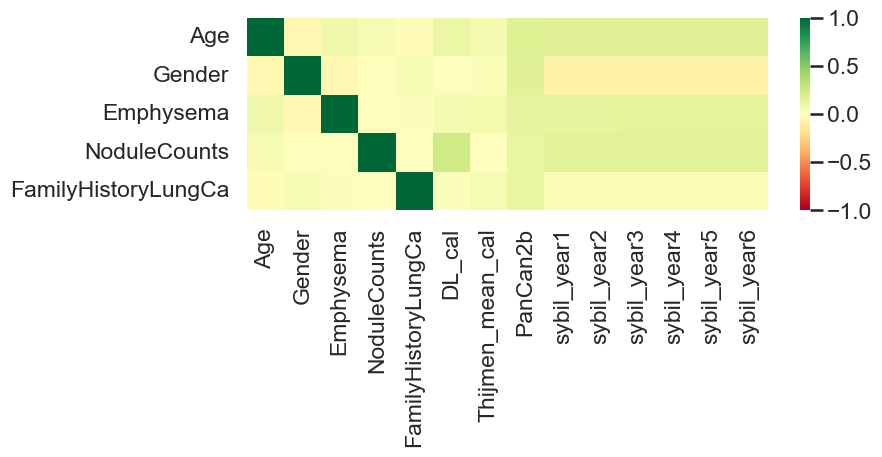

### dlcst

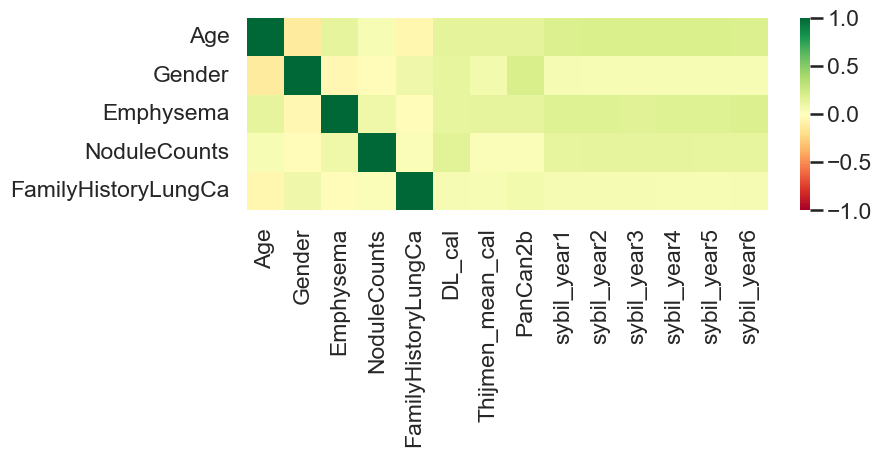

### diff_nlst_dlcst

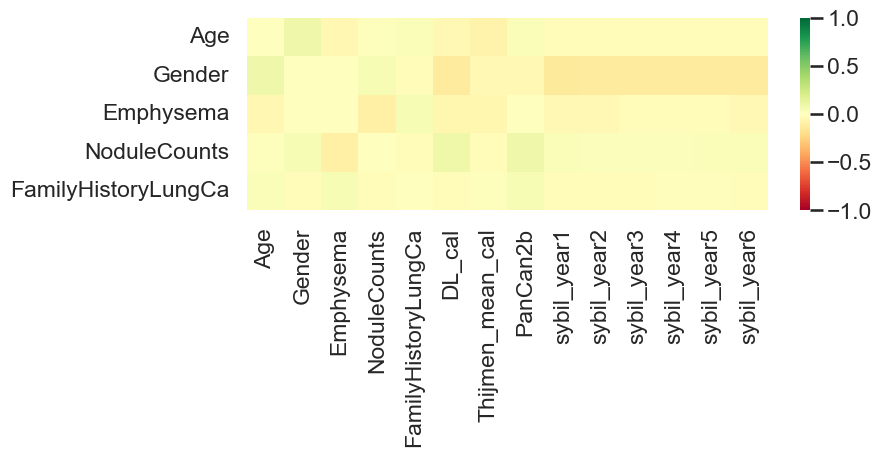

In [47]:
correlations = {m: screening_sets[m][dlcst_demo_list + dlcst_pred_list].corr(method='spearman').round(2) for m in screening_sets}
corr0 = correlations.copy()    
for i, m1 in enumerate(corr0):
    for j, m2 in enumerate(corr0):
        if j > i:
            correlations[f"diff_{m1}_{m2}"] = correlations[f"{m1}"] - correlations[f"{m2}"]

for m in correlations:
    corr_rows = dlcst_demo_list
    corr_cols = corr_rows + dlcst_pred_list
    # corr_cols = cols_list
    
    display(Markdown(f"### {m}"))
    plt.figure(figsize=(len(corr_cols) * 0.6, len(corr_rows) * 0.5))
    sns.heatmap(correlations[m].loc[corr_rows, corr_cols], cmap='RdYlGn', vmin=-1, vmax=1)
    plt.show()

## What about men vs. women?

### Training sets

In [48]:
sybil_train_m = sybil_train.query('Gender == 1')
sybil_train_f = sybil_train.query('Gender == 2')

gender_train_sets = {
    "M":sybil_train_m,
    "F":sybil_train_f,
}

In [49]:
cat_demo_gender = combine_col_dfs(nlst_democols['cat'], cat_dist_df, gender_train_sets).query('value != 0')
display(cat_demo_gender.sort_values(by='diff_norm_M_F', ascending=False).head(40))
cat_demo_gender.sort_values(by='diff_norm_M_F', ascending=True).head(40)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
60,smoke,pipe,1.0,6186.0,37.3280,243.0,2.0970,35.2310
52,smoke,cigar,1.0,5465.0,32.9773,477.0,4.1163,28.8610
14,demo,Married,1.0,12987.0,78.3671,6295.0,54.3234,24.0437
29,demo,marital,2.0,12987.0,78.3671,6295.0,54.3234,24.0437
201,other,wrknomask,1.0,5486.0,33.1040,1495.0,12.9013,20.2027
1,demo,Overweight,1.0,12764.0,77.0215,7134.0,61.5637,15.4578
81,work,wrkfarm,1.0,2504.0,15.1098,614.0,5.2986,9.8112
129,disease,diaghear,1.0,2732.0,16.4856,922.0,7.9565,8.5291
90,work,wrkweld,1.0,1512.0,9.1238,85.0,0.7335,8.3903
72,work,wrkasbe,1.0,1256.0,7.5790,65.0,0.5609,7.0181


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
32,demo,marital,5.0,2148.0,12.9616,3057.0,26.3807,-13.4191
30,demo,marital,3.0,566.0,3.4154,1489.0,12.8495,-9.4341
49,smoke,smokelive,1.0,13873.0,83.7135,10752.0,92.7856,-9.0721
111,disease,diagpneu,1.0,3095.0,18.6761,3183.0,27.4681,-8.7920
150,disease,diagchro,1.0,1132.0,6.8308,1618.0,13.9627,-7.1319
4,demo,educat,3.0,3398.0,20.5045,3183.0,27.4681,-6.9636
199,other,PersonalCancerHist,1.0,274.0,1.6534,814.0,7.0245,-5.3711
135,disease,diagadas,1.0,658.0,3.9706,1072.0,9.2509,-5.2803
55,smoke,cigsmok,1.0,7553.0,45.5769,5833.0,50.3366,-4.7597
20,demo,Unfinished_ed,1.0,4390.0,26.4905,3522.0,30.3935,-3.9030


In [87]:
display(cat_demo_gender.sort_values(by='diff_norm_M_F', ascending=False).query('category == "lungcanc"'))
cat_demo_gender.sort_values(by='diff_norm_M_F', ascending=True).query('category == "lungcanc"')

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
225,lungcanc,Squamous_cell_carcinoma,1.0,250.0,1.5086,106.0,0.9147,0.5939
211,lungcanc,LC_stage,400.0,254.0,1.5327,130.0,1.1219,0.4108
207,lungcanc,LC_stage,210.0,70.0,0.4224,28.0,0.2416,0.1808
213,lungcanc,LC_stage,NaN,15737.0,94.9614,10988.0,94.8222,0.1392
217,lungcanc,Small_cell_carcinoma,1.0,119.0,0.7181,80.0,0.6904,0.0277
208,lungcanc,LC_stage,220.0,29.0,0.1750,18.0,0.1553,0.0197
215,lungcanc,Adenosquamous_carcinoma,1.0,14.0,0.0845,10.0,0.0863,-0.0018
212,lungcanc,LC_stage,900.0,3.0,0.0181,3.0,0.0259,-0.0078
227,lungcanc,Unclassified_carcinoma,1.0,92.0,0.5552,66.0,0.5696,-0.0144
209,lungcanc,LC_stage,310.0,102.0,0.6155,74.0,0.6386,-0.0231


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
205,lungcanc,LC_stage,110.0,284.0,1.7137,265.0,2.2868,-0.5731
219,lungcanc,Bronchiolo-alveolar_carcinoma,1.0,47.0,0.2836,76.0,0.6559,-0.3723
223,lungcanc,Adenocarcinoma,1.0,305.0,1.8405,253.0,2.1833,-0.3428
210,lungcanc,LC_stage,320.0,32.0,0.1931,32.0,0.2761,-0.0830
206,lungcanc,LC_stage,120.0,61.0,0.3681,50.0,0.4315,-0.0634
229,lungcanc,Large_cell_carcinoma,1.0,18.0,0.1086,17.0,0.1467,-0.0381
221,lungcanc,Carcinoid_tumor,1.0,1.0,0.0060,4.0,0.0345,-0.0285
209,lungcanc,LC_stage,310.0,102.0,0.6155,74.0,0.6386,-0.0231
227,lungcanc,Unclassified_carcinoma,1.0,92.0,0.5552,66.0,0.5696,-0.0144
212,lungcanc,LC_stage,900.0,3.0,0.0181,3.0,0.0259,-0.0078


In [51]:
num_demo_gender = combine_col_dfs(nlst_democols['num'], num_dist_df, gender_train_sets)
display(num_demo_gender.sort_values(by='diff_M_F', ascending=False).head(20))
num_demo_gender.sort_values(by='diff_M_F', ascending=True).head(20)

,category,attribute,value,M,F,diff_M_F
6,demo,weight,50%,195.0000,157.0000,38.0000
7,demo,weight,mean,198.2521,162.1246,36.1275
10,smoke,smokeday,50%,30.0000,20.0000,10.0000
15,smoke,pkyr,mean,59.6811,51.0970,8.5841
14,smoke,pkyr,50%,52.0000,45.0000,7.0000
4,demo,height,50%,70.0000,64.0000,6.0000
5,demo,height,mean,70.2740,64.4574,5.8166
11,smoke,smokeday,mean,29.8936,26.3792,3.5144
2,demo,Age,50%,61.0000,60.0000,1.0000
0,demo,BMI,50%,27.5461,26.5684,0.9777


,category,attribute,value,M,F,diff_M_F
9,smoke,smokeage,mean,16.2727,17.3593,-1.0866
8,smoke,smokeage,50%,16.0000,17.0000,-1.0000
12,smoke,smokeyr,50%,40.0000,40.0000,0.0000
3,demo,Age,mean,61.8288,61.3933,0.4355
1,demo,BMI,mean,28.1879,27.4096,0.7783
13,smoke,smokeyr,mean,40.3346,39.4056,0.9290
0,demo,BMI,50%,27.5461,26.5684,0.9777
2,demo,Age,50%,61.0000,60.0000,1.0000
11,smoke,smokeday,mean,29.8936,26.3792,3.5144
5,demo,height,mean,70.2740,64.4574,5.8166


In [52]:
cat_demo_gender[cat_demo_gender['attribute'].isin(set(sybil_worse_df['col']))].query('value == 1').sort_values(by='diff_norm_M_F', ascending=True)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
111,disease,diagpneu,1.0,3095.0,18.6761,3183.0,27.4681,-8.7920
135,disease,diagadas,1.0,658.0,3.9706,1072.0,9.2509,-5.2803
197,other,FamilyHistoryLungCa,1.0,3476.0,20.9751,2756.0,23.7832,-2.8081
138,disease,diagcopd,1.0,722.0,4.3567,755.0,6.5154,-2.1587
203,other,Emphysema,1.0,1444.0,8.7135,873.0,7.5337,1.1798
66,work,wrkfoun,1.0,1139.0,6.8730,94.0,0.8112,6.0618
72,work,wrkasbe,1.0,1256.0,7.5790,65.0,0.5609,7.0181
201,other,wrknomask,1.0,5486.0,33.1040,1495.0,12.9013,20.2027
14,demo,Married,1.0,12987.0,78.3671,6295.0,54.3234,24.0437
11,demo,Gender,1.0,16572.0,100.0000,NaN,NaN,NaN


### Evaluation sets (Kiran data)

In [53]:
with open(f'{NLST_PREDS}/nlst_demo_v4_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

nlst_democols['num'].pop('nodule')
nlst_democols['cat']['other'].append('label')

In [54]:
nlst_democols

{'num': {'demo': ['BMI', 'Age', 'height', 'weight'],
  'smoke': ['smokeage', 'smokeday', 'smokeyr', 'pkyr'],
  'other': ['NoduleCounts', 'Diameter [mm]']},
 'cat': {'demo': ['Overweight',
   'educat',
   'Gender',
   'Married',
   'HighSchoolPlus',
   'NonHispanicWhite',
   'Unfinished_ed',
   'WhiteOrBlack',
   'marital',
   'ethnic',
   'race'],
  'smoke': ['smokelive', 'cigar', 'cigsmok', 'smokework', 'pipe'],
  'work': ['wrkbaki',
   'wrkfoun',
   'wrkchem',
   'wrkasbe',
   'wrkfire',
   'wrksand',
   'wrkfarm',
   'wrkcoal',
   'wrkpain',
   'wrkweld',
   'wrkflou',
   'wrkbutc',
   'wrkhard',
   'wrkcott'],
  'disease': ['diagasbe',
   'diagchas',
   'diagpneu',
   'diagstro',
   'diagemph',
   'diagbron',
   'diagsili',
   'diagsarc',
   'diaghear',
   'diagdiab',
   'diagadas',
   'diagcopd',
   'diagfibr',
   'diagtube',
   'diaghype',
   'diagchro'],
  'canchist': ['canckidn',
   'cancphar',
   'canccolo',
   'cancoral',
   'cancpanc',
   'canccerv',
   'cancstom',
   'canct

In [55]:
kiran_data_m = kiran_data.query('Gender == 1')
kiran_data_f = kiran_data.query('Gender == 2')

gender_eval_sets = {
    "M":kiran_data_m,
    "F":kiran_data_f,
}

In [56]:
cat_gender_eval = combine_col_dfs(nlst_democols['cat'], cat_dist_df, gender_eval_sets).query('value != 0')
display(cat_gender_eval.sort_values(by='diff_norm_M_F', ascending=False).head(40))
cat_gender_eval.sort_values(by='diff_norm_M_F', ascending=True).head(40)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
51,smoke,pipe,1.0,2133.0,36.5615,88.0,2.0235,34.5380
43,smoke,cigar,1.0,1795.0,30.7679,139.0,3.1961,27.5718
13,demo,Married,1.0,4531.0,77.6654,2324.0,53.4376,24.2278
24,demo,marital,2.0,4531.0,77.6654,2324.0,53.4376,24.2278
210,other,wrknomask,1.0,2005.0,34.3675,577.0,13.2674,21.1001
1,demo,Overweight,1.0,4318.0,74.0144,2645.0,60.8186,13.1958
72,work,wrkfarm,1.0,907.0,15.5468,262.0,6.0244,9.5224
202,nodule,Solid,1.0,4074.0,69.8320,2626.0,60.3817,9.4503
120,disease,diaghear,1.0,983.0,16.8495,349.0,8.0248,8.8247
81,work,wrkweld,1.0,552.0,9.4618,44.0,1.0117,8.4501


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
27,demo,marital,5.0,797.0,13.6613,1107.0,25.4541,-11.7928
25,demo,marital,3.0,205.0,3.5139,659.0,15.1529,-11.6390
102,disease,diagpneu,1.0,1086.0,18.6150,1270.0,29.2021,-10.5871
40,smoke,smokelive,1.0,4887.0,83.7676,4078.0,93.7687,-10.0011
188,nodule,GroundGlassOpacity,1.0,1406.0,24.1001,1453.0,33.4100,-9.3099
141,disease,diagchro,1.0,393.0,6.7364,671.0,15.4288,-8.6924
126,disease,diagadas,1.0,205.0,3.5139,461.0,10.6001,-7.0862
4,demo,educat,3.0,1284.0,22.0089,1254.0,28.8342,-6.8253
208,other,PersonalCancerHist,1.0,120.0,2.0569,357.0,8.2088,-6.1519
206,other,FamilyHistoryLungCa,1.0,1384.0,23.7230,1238.0,28.4663,-4.7433


In [66]:
display(cat_gender_eval.query('category == "nodule"').sort_values(by='diff_norm_M_F', ascending=False).head(40))
cat_gender_eval.query('category == "nodule"').sort_values(by='diff_norm_M_F', ascending=True).head(40)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
202,nodule,Solid,1.0,4074.0,69.8320,2626.0,60.3817,9.4503
192,nodule,Perifissural,1.0,564.0,9.6675,261.0,6.0014,3.6661
196,nodule,Calcified,1.0,5.0,0.0857,3.0,0.0690,0.0167
198,nodule,Spiculation,1.0,10.0,0.1714,10.0,0.2299,-0.0585
194,nodule,NonSolid,1.0,66.0,1.1313,58.0,1.3336,-0.2023
200,nodule,PartSolid,1.0,101.0,1.7312,139.0,3.1961,-1.4649
204,nodule,SemiSolid,1.0,666.0,11.4158,640.0,14.7160,-3.3002
190,nodule,NoduleInUpperLung,1.0,2919.0,50.0343,2343.0,53.8745,-3.8402
188,nodule,GroundGlassOpacity,1.0,1406.0,24.1001,1453.0,33.4100,-9.3099


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
188,nodule,GroundGlassOpacity,1.0,1406.0,24.1001,1453.0,33.4100,-9.3099
190,nodule,NoduleInUpperLung,1.0,2919.0,50.0343,2343.0,53.8745,-3.8402
204,nodule,SemiSolid,1.0,666.0,11.4158,640.0,14.7160,-3.3002
200,nodule,PartSolid,1.0,101.0,1.7312,139.0,3.1961,-1.4649
194,nodule,NonSolid,1.0,66.0,1.1313,58.0,1.3336,-0.2023
198,nodule,Spiculation,1.0,10.0,0.1714,10.0,0.2299,-0.0585
196,nodule,Calcified,1.0,5.0,0.0857,3.0,0.0690,0.0167
192,nodule,Perifissural,1.0,564.0,9.6675,261.0,6.0014,3.6661
202,nodule,Solid,1.0,4074.0,69.8320,2626.0,60.3817,9.4503


In [58]:
display(cat_gender_eval.query('attribute == "LC_stage"').sort_values(by='diff_norm_M_F', ascending=False).head(40))
cat_gender_eval.query('attribute == "LC_stage"').sort_values(by='diff_norm_M_F', ascending=True).head(40)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
221,lungcanc,LC_stage,400.0,125.0,2.1426,44.0,1.0117,1.1309
217,lungcanc,LC_stage,210.0,65.0,1.1142,19.0,0.4369,0.6773
220,lungcanc,LC_stage,320.0,20.0,0.3428,11.0,0.2529,0.0899
219,lungcanc,LC_stage,310.0,78.0,1.3370,58.0,1.3336,0.0034
222,lungcanc,LC_stage,900.0,1.0,0.0171,3.0,0.0690,-0.0519
216,lungcanc,LC_stage,120.0,61.0,1.0456,51.0,1.1727,-0.1271
218,lungcanc,LC_stage,220.0,18.0,0.3085,22.0,0.5059,-0.1974
223,lungcanc,LC_stage,NaN,5154.0,88.3442,3857.0,88.6871,-0.3429
215,lungcanc,LC_stage,110.0,312.0,5.3480,284.0,6.5302,-1.1822


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
215,lungcanc,LC_stage,110.0,312.0,5.3480,284.0,6.5302,-1.1822
223,lungcanc,LC_stage,NaN,5154.0,88.3442,3857.0,88.6871,-0.3429
218,lungcanc,LC_stage,220.0,18.0,0.3085,22.0,0.5059,-0.1974
216,lungcanc,LC_stage,120.0,61.0,1.0456,51.0,1.1727,-0.1271
222,lungcanc,LC_stage,900.0,1.0,0.0171,3.0,0.0690,-0.0519
219,lungcanc,LC_stage,310.0,78.0,1.3370,58.0,1.3336,0.0034
220,lungcanc,LC_stage,320.0,20.0,0.3428,11.0,0.2529,0.0899
217,lungcanc,LC_stage,210.0,65.0,1.1142,19.0,0.4369,0.6773
221,lungcanc,LC_stage,400.0,125.0,2.1426,44.0,1.0117,1.1309


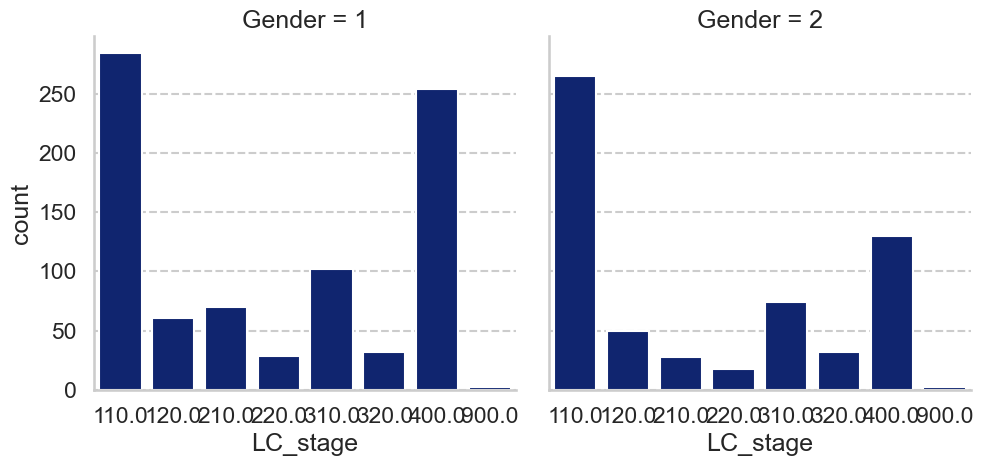

In [85]:
sns.catplot(sybil_train, x='LC_stage', col='Gender', kind='count')

In [59]:
num_gender_eval = combine_col_dfs(nlst_democols['num'], num_dist_df, gender_eval_sets)
display(num_gender_eval.sort_values(by='diff_M_F', ascending=False).head(20))
num_gender_eval.sort_values(by='diff_M_F', ascending=True).head(20)

,category,attribute,value,M,F,diff_M_F
6,demo,weight,50%,193.0000,157.0000,36.0000
7,demo,weight,mean,196.7960,161.7294,35.0666
10,smoke,smokeday,50%,30.0000,20.0000,10.0000
15,smoke,pkyr,mean,62.0469,52.5078,9.5391
14,smoke,pkyr,50%,55.0000,46.0000,9.0000
4,demo,height,50%,70.0000,64.0000,6.0000
5,demo,height,mean,70.4206,64.4917,5.9289
11,smoke,smokeday,mean,30.2072,26.3831,3.8241
13,smoke,smokeyr,mean,41.4820,40.3663,1.1157
2,demo,Age,50%,63.0000,62.0000,1.0000


,category,attribute,value,M,F,diff_M_F
9,smoke,smokeage,mean,16.1409,17.2138,-1.0729
8,smoke,smokeage,50%,16.0000,17.0000,-1.0000
16,other,NoduleCounts,mean,1.8819,1.8857,-0.0038
17,other,Diameter [mm],50%,7.3000,7.2000,0.1000
18,other,Diameter [mm],mean,9.4266,8.9452,0.4814
1,demo,BMI,mean,27.8551,27.3230,0.5321
3,demo,Age,mean,63.4344,62.8972,0.5372
0,demo,BMI,50%,27.2592,26.5180,0.7412
2,demo,Age,50%,63.0000,62.0000,1.0000
12,smoke,smokeyr,50%,41.0000,40.0000,1.0000


In [60]:
cat_gender_eval[cat_gender_eval['attribute'].isin(set(sybil_worse_df['col']))].query('value == 1').sort_values(by='diff_norm_M_F', ascending=True)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
102,disease,diagpneu,1.0,1086.0,18.6150,1270.0,29.2021,-10.5871
126,disease,diagadas,1.0,205.0,3.5139,461.0,10.6001,-7.0862
206,other,FamilyHistoryLungCa,1.0,1384.0,23.7230,1238.0,28.4663,-4.7433
129,disease,diagcopd,1.0,336.0,5.7593,340.0,7.8179,-2.0586
212,other,Emphysema,1.0,2242.0,38.4299,1455.0,33.4560,4.9739
57,work,wrkfoun,1.0,412.0,7.0621,29.0,0.6668,6.3953
63,work,wrkasbe,1.0,453.0,7.7648,28.0,0.6438,7.1210
210,other,wrknomask,1.0,2005.0,34.3675,577.0,13.2674,21.1001
13,demo,Married,1.0,4531.0,77.6654,2324.0,53.4376,24.2278
10,demo,Gender,1.0,5834.0,100.0000,NaN,NaN,NaN


## What about race?

### Kiran data

In [61]:
kiran_data_white = kiran_data.query('race == 1')
kiran_data_black = kiran_data.query('race == 2')

race_kiran_sets = {
    "white":kiran_data_white,
    "black":kiran_data_black,
}

In [89]:
cat_race_kiran = combine_col_dfs(nlst_democols['cat'], cat_dist_df, race_kiran_sets).query('value != 0')
display(cat_race_kiran.sort_values(by='diff_norm_white_black', ascending=False).head(40))
cat_race_kiran.sort_values(by='diff_norm_white_black', ascending=True).head(40)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
23,demo,marital,2.0,6464.0,68.3226,127.0,37.5740,30.7486
13,demo,Married,1.0,6464.0,68.3226,127.0,37.5740,30.7486
45,smoke,pipe,1.0,2147.0,22.6932,27.0,7.9882,14.7050
10,demo,Gender,1.0,5432.0,57.4146,149.0,44.0828,13.3318
62,work,wrkfarm,1.0,1125.0,11.8909,9.0,2.6627,9.2282
4,demo,educat,3.0,2410.0,25.4730,61.0,18.0473,7.4257
37,smoke,cigar,1.0,1838.0,19.4271,41.0,12.1302,7.2969
5,demo,educat,4.0,1345.0,14.2163,28.0,8.2840,5.9323
7,demo,educat,6.0,1493.0,15.7806,35.0,10.3550,5.4256
206,lungcanc,LC_stage,NaN,8387.0,88.6481,282.0,83.4320,5.2161


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
121,disease,diaghype,1.0,3203.0,33.8548,195.0,57.6923,-23.8375
40,smoke,cigsmok,1.0,4665.0,49.3077,232.0,68.6391,-19.3314
19,demo,Unfinished_ed,1.0,2547.0,26.9210,152.0,44.9704,-18.0494
26,demo,marital,5.0,1715.0,18.1270,114.0,33.7278,-15.6008
11,demo,Gender,2.0,4029.0,42.5854,189.0,55.9172,-13.3318
106,disease,diagdiab,1.0,831.0,8.7834,67.0,19.8225,-11.0391
3,demo,educat,2.0,454.0,4.7986,48.0,14.2012,-9.4026
6,demo,educat,5.0,2093.0,22.1224,104.0,30.7692,-8.6468
52,work,wrkchem,1.0,604.0,6.3841,43.0,12.7219,-6.3378
24,demo,marital,3.0,792.0,8.3712,46.0,13.6095,-5.2383


In [63]:
display(cat_race_kiran.query('category == "nodule"').sort_values(by='diff_norm_white_black', ascending=False).head(40))
cat_race_kiran.query('category == "nodule"').sort_values(by='diff_norm_white_black', ascending=True).head(40)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
175,nodule,Perifissural,1.0,779.0,8.2338,18.0,5.3254,2.9084
185,nodule,Solid,1.0,6275.0,66.3249,218.0,64.4970,1.8279
183,nodule,PartSolid,1.0,226.0,2.3888,5.0,1.4793,0.9095
177,nodule,NonSolid,1.0,120.0,1.2684,3.0,0.8876,0.3808
173,nodule,NoduleInUpperLung,1.0,4879.0,51.5696,179.0,52.9586,-1.3890
171,nodule,GroundGlassOpacity,1.0,2632.0,27.8195,99.0,29.2899,-1.4704
187,nodule,SemiSolid,1.0,1194.0,12.6202,50.0,14.7929,-2.1727
179,nodule,Calcified,1.0,8.0,0.0846,NaN,NaN,NaN
181,nodule,Spiculation,1.0,19.0,0.2008,NaN,NaN,NaN


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
187,nodule,SemiSolid,1.0,1194.0,12.6202,50.0,14.7929,-2.1727
171,nodule,GroundGlassOpacity,1.0,2632.0,27.8195,99.0,29.2899,-1.4704
173,nodule,NoduleInUpperLung,1.0,4879.0,51.5696,179.0,52.9586,-1.3890
177,nodule,NonSolid,1.0,120.0,1.2684,3.0,0.8876,0.3808
183,nodule,PartSolid,1.0,226.0,2.3888,5.0,1.4793,0.9095
185,nodule,Solid,1.0,6275.0,66.3249,218.0,64.4970,1.8279
175,nodule,Perifissural,1.0,779.0,8.2338,18.0,5.3254,2.9084
179,nodule,Calcified,1.0,8.0,0.0846,NaN,NaN,NaN
181,nodule,Spiculation,1.0,19.0,0.2008,NaN,NaN,NaN


In [64]:
display(cat_race_kiran.query('attribute == "LC_stage"').sort_values(by='diff_norm_white_black', ascending=False).head(40))
cat_race_kiran.query('attribute == "LC_stage"').sort_values(by='diff_norm_white_black', ascending=True).head(40)

,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
206,lungcanc,LC_stage,NaN,8387.0,88.6481,282.0,83.4320,5.2161
199,lungcanc,LC_stage,120.0,106.0,1.1204,4.0,1.1834,-0.0630
200,lungcanc,LC_stage,210.0,77.0,0.8139,3.0,0.8876,-0.0737
201,lungcanc,LC_stage,220.0,36.0,0.3805,2.0,0.5917,-0.2112
204,lungcanc,LC_stage,400.0,157.0,1.6594,7.0,2.0710,-0.4116
202,lungcanc,LC_stage,310.0,119.0,1.2578,6.0,1.7751,-0.5173
203,lungcanc,LC_stage,320.0,26.0,0.2748,5.0,1.4793,-1.2045
198,lungcanc,LC_stage,110.0,549.0,5.8028,29.0,8.5799,-2.7771
205,lungcanc,LC_stage,900.0,4.0,0.0423,NaN,NaN,NaN


,category,attribute,value,white_freq,white_norm,black_freq,black_norm,diff_norm_white_black
198,lungcanc,LC_stage,110.0,549.0,5.8028,29.0,8.5799,-2.7771
203,lungcanc,LC_stage,320.0,26.0,0.2748,5.0,1.4793,-1.2045
202,lungcanc,LC_stage,310.0,119.0,1.2578,6.0,1.7751,-0.5173
204,lungcanc,LC_stage,400.0,157.0,1.6594,7.0,2.0710,-0.4116
201,lungcanc,LC_stage,220.0,36.0,0.3805,2.0,0.5917,-0.2112
200,lungcanc,LC_stage,210.0,77.0,0.8139,3.0,0.8876,-0.0737
199,lungcanc,LC_stage,120.0,106.0,1.1204,4.0,1.1834,-0.0630
206,lungcanc,LC_stage,NaN,8387.0,88.6481,282.0,83.4320,5.2161
205,lungcanc,LC_stage,900.0,4.0,0.0423,NaN,NaN,NaN


In [65]:
num_race_kiran = combine_col_dfs(nlst_democols['num'], num_dist_df, race_kiran_sets)
display(num_race_kiran.sort_values(by='diff_white_black', ascending=False).head(20))
num_race_kiran.sort_values(by='diff_white_black', ascending=True).head(20)

,category,attribute,value,white,black,diff_white_black
15,smoke,pkyr,mean,58.2982,49.4726,8.8256
14,smoke,pkyr,50%,51.0000,44.0000,7.0000
11,smoke,smokeday,mean,28.7498,23.3994,5.3504
10,smoke,smokeday,50%,25.0000,20.0000,5.0000
6,demo,weight,50%,180.0000,178.0000,2.0000
7,demo,weight,mean,182.0639,180.8542,1.2097
2,demo,Age,50%,63.0000,62.0000,1.0000
4,demo,height,50%,68.0000,67.0000,1.0000
5,demo,height,mean,67.9504,67.2047,0.7457
3,demo,Age,mean,63.2459,62.6095,0.6364


,category,attribute,value,white,black,diff_white_black
13,smoke,smokeyr,mean,40.9904,42.3077,-1.3173
8,smoke,smokeage,50%,16.0000,17.0000,-1.0000
12,smoke,smokeyr,50%,41.0000,42.0000,-1.0000
1,demo,BMI,mean,27.6099,28.3226,-0.7127
18,other,Diameter [mm],mean,9.2075,9.8432,-0.6357
17,other,Diameter [mm],50%,7.2000,7.6500,-0.4500
9,smoke,smokeage,mean,16.5805,16.8876,-0.3071
16,other,NoduleCounts,mean,1.8937,1.7929,0.1008
0,demo,BMI,50%,27.0435,26.6853,0.3582
3,demo,Age,mean,63.2459,62.6095,0.6364
